In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tqdm.notebook import tqdm, trange
import pickle as pkl

In [2]:
# Erstellt August 2020
# (c) mha

def create_sea(seed=None):
    'Creates a sea with random ships on it'
    rng = random.Random(seed)
    sea = np.zeros((10,10))
    #for l in [5, 4, 3, 2]: # Länge
    for l in [5,4,3,2]: # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = rng.random() < 0.5
                if t: sea = sea.T # Transponieren
                px = rng.randint(0, 10-l)
                py = rng.randint(0, 9)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                if t: sea = sea.T # Transponieren
                break
    return sea

def create_detection(seed=None, l=5):
    'Creates a random detected array (for test purposes)'
    rng = random.Random(seed)
    det = np.zeros((10,10))
    px = rng.randint(0, 10-l)
    py = rng.randint(0, 9)
    det[px:px+l, py] = 1
    
    if rng.random() < 0.5: 
        det = det.T
    return det

def visualize(sea, detection):
    'Erstellt eine Veranschaulichung, 0 bzw. 4 sind detektiertes Wasser bzw. Schiff, 1 und 2 sind undetektiert.'
    return sea + sea*detection + 1 - ((1-sea)*detection)

def plot_sea(sea, det, ax=None):
    if ax is None: ax = plt.gca()
    #ax.imshow(visualize(sea, det), vmin=-2, cmap='plasma')
    ax.imshow(visualize(sea, det), vmin=-1, vmax=3.15, cmap='cividis')
    ax.axis('off')

In [3]:
from numba import njit, jit

@njit(cache=True)
def njit_create_sea():
    'Creates a sea with random ships on it'
    sea = np.zeros((10,10))
    for l in [5,4,3,2]: # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = np.random.rand() < 0.5
                if t: sea = sea.T # Transponieren
                px = np.random.randint(0, 11-l)
                py = np.random.randint(0, 10)
                if np.sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                if t: sea = sea.T # Transponieren
                break
    return sea

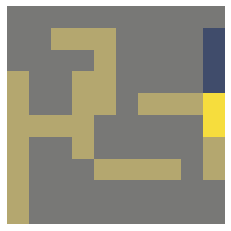

In [4]:
sea = create_sea(0)
#detection = np.zeros((10,10))
#detection[4, 0:5] = 1.
det = create_detection(l=5, seed=1)
###detected = detect(sea, det)

plt.imshow(sea*255)
plot_sea(sea, det)

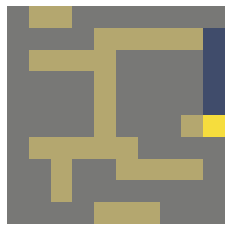

In [5]:
sea = njit_create_sea()
det = create_detection(l=5, seed=1)

plt.imshow(sea*255)
plot_sea(sea, det)

### Modell trainieren

In [29]:
def encode_x(sea, det):
    'Encodes the visible information to an input to the neural network'
    return np.stack([(1-sea)*det, (1-det), sea*det], -1)
    

def batchgen(size=50):
    while True:
        xs, ys = [], []
        for _ in range(size):
            sea = njit_create_sea()
            r = np.random.rand()
            if r < 0.25:
                det = np.random.rand(10,10) < np.random.rand()
            elif r < 0.5:
                det = np.random.rand(10,10) < 1/30*np.random.rand()
            elif r < 0.75:
                det = np.random.rand(10,10) < 1/6*np.random.rand()
            else:
                det = np.random.rand(10,10) < 0.5*np.random.rand()
            x = encode_x(sea, det)
            xs.append(x)
            ys.append(sea.reshape((10,10,1)))
        yield np.array(xs), np.array(ys)
        

In [52]:

import torch
from torch import nn
from utils import *

relu = torch.nn.ReLU()
sigmoid = torch.nn.Sigmoid()

class ResBlock(nn.Module):
    def __init__(self, n, sz=3, bn=True):
        super().__init__()
        self.bn = bn
        if bn:
            self.conv1 = nn.Conv2d(n, n, sz, padding=sz//2)
            self.conv2 = nn.Conv2d(n, n, sz, padding=sz//2)
            self.bn1 = nn.BatchNorm2d(n)
            self.bn2 = nn.BatchNorm2d(n)
        else:
            self.conv1 = nn.Conv2d(n, n, sz, padding=sz//2)
            self.conv2 = nn.Conv2d(n, n, sz, padding=sz//2)
            
    def forward(self, x):
        x0 = x
        if self.bn:
            x = self.bn1(x)
            x = relu(x)
            x = self.conv1(x)
            x = self.bn2(x)
            x = relu(x)
            x = self.conv2(x)
        else:
            x = relu(x)
            x = self.conv1(x)
            x = relu(x)
            x = self.conv2(x)
        return x0 + x

class bship_nnet(nn.Module):
    def __init__(self, n=64, nblocks=10):
        'BattleShip CNN. More than 1 blocks didnt make a difference.'
        super().__init__()
        self.conv1 = nn.Conv2d(3, n, 5, padding=2)
        self.resblocks = nn.ModuleList([ ResBlock(n) for _ in range(nblocks) ])
        self.conv_m2 = nn.Conv2d(n, n, 3, padding=1)
        self.conv_m1 = nn.Conv2d(n, 1, 3, padding=1)
        
    def forward(self, x):
        # NHWC zu NCHW
        x = x.permute([0, 3, 1, 2])
        
        x = self.conv1(x)
        #x_res = x = relu(x)
        for block in self.resblocks:
            x = block(x)
        #x = self.conv_m2(x)
        #x = x_res + x
        x = self.conv_m1(x)
        x = sigmoid(x)
        
        # NCHW zu NHWC
        x = x.permute([0, 2, 3, 1])
        return x
    
    def predict(self, x):
        'Takes a numpy array and give out one, i. e. 10x10 -> 10x10'
        x = np2t(x[None,:])
        y = self(x)
        return t2np(y[0,:,:,0])
    
    
def augment(x, y):
    r = np.random.rand
    if r()<0.5:
        x, y = x.flip(1), y.flip(1)
    if r()<0.5:
        x, y = x.flip(2), y.flip(2)
    if r()<0.5:
        x, y = x.transpose(1,2), y.transpose(1,2)
    return x, y

net = bship_nnet()
optimizer = torch.optim.Adam(lr=1e-3, params=net.parameters())
net.losses = []
net.iters = 0
net.cuda();

teacher = bship_nnet().cuda()
teacher.load_state_dict(net.state_dict());
teacher.eval();

In [58]:
optimizer = torch.optim.Adam(lr=1e-4, params=net.parameters())
tau = 0.95
bg = batchgen(256)

  0%|          | 0/400000 [00:00<?, ?it/s]

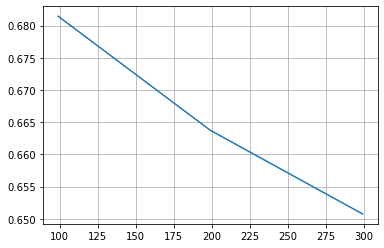

0.04421517465030775


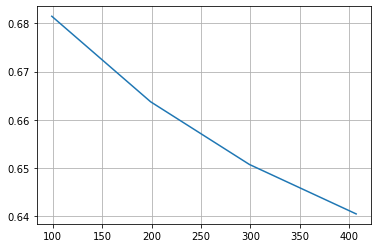

0.015147006013139617


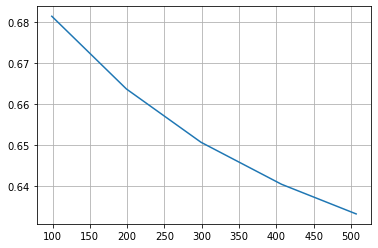

0.012410126467584633


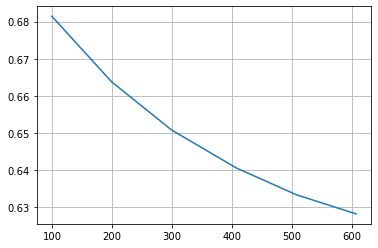

0.010295167602598666


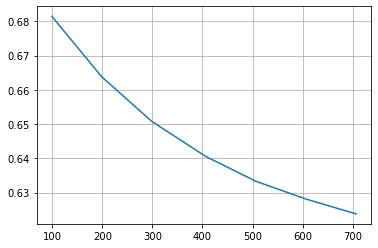

0.008973772334284149


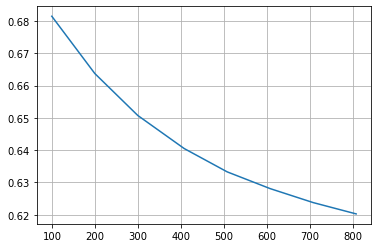

0.009383341482607648


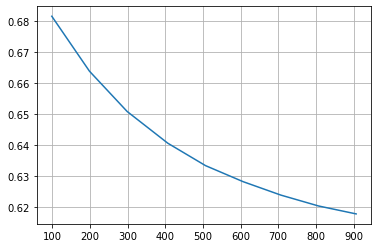

0.009587967515108176


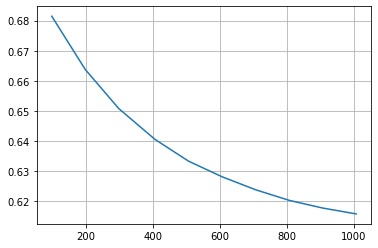

0.008801033250638284


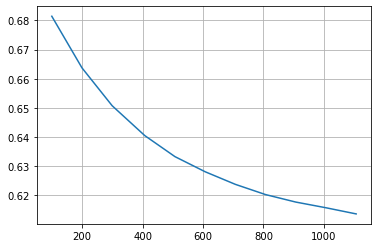

0.008606421977747232


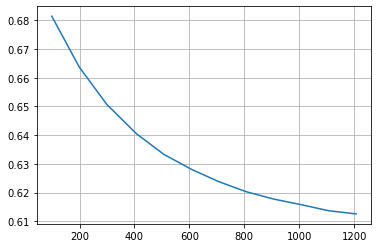

0.00749722164706327


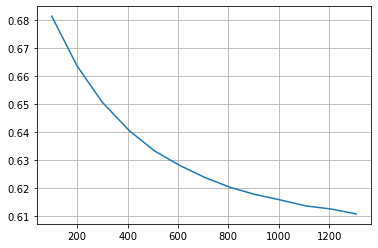

0.007470969940768555


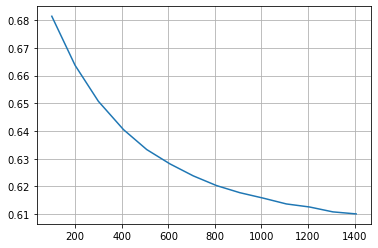

0.006521805596421472


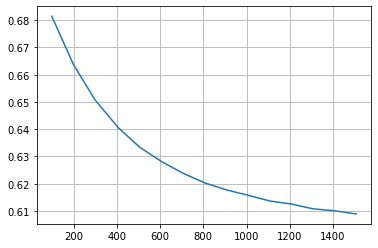

0.006807989563967567


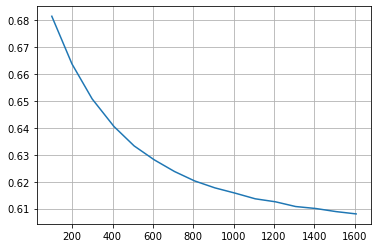

0.006494019693927839


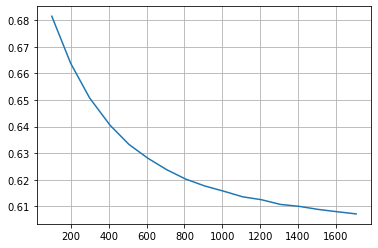

0.0063464657528675165


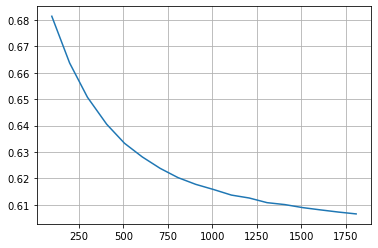

0.0063976526330225165


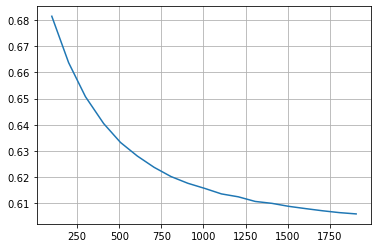

0.006307011179160327


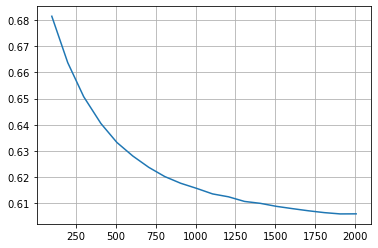

0.006250207354023587


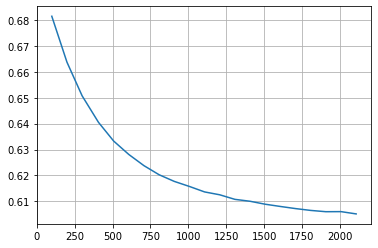

0.005592275249946397


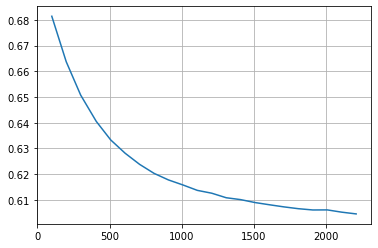

0.00547916361130774


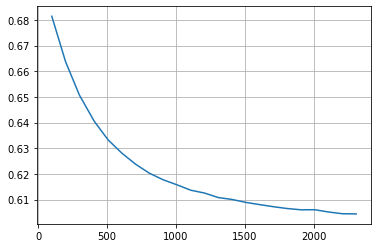

0.00549749284342397


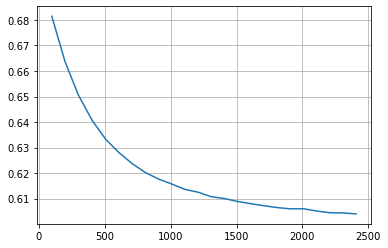

0.006295379613293335


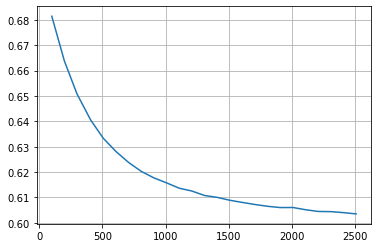

0.005308254126284737


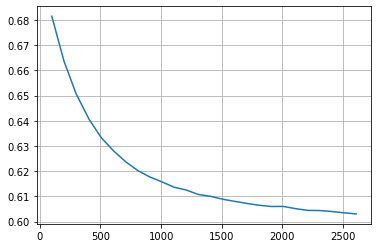

0.005970826023258269


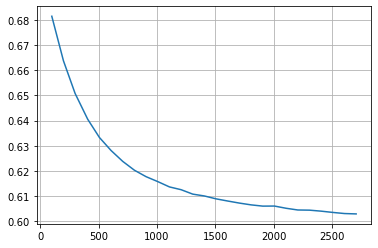

0.005021689365676139


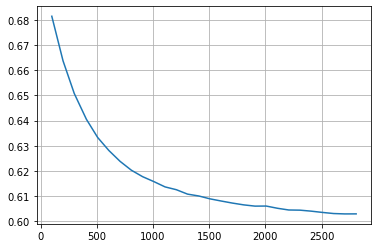

0.00499014732777141


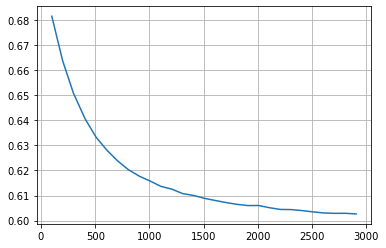

0.004764002085139509


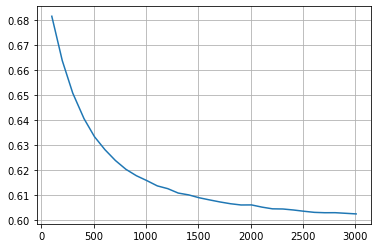

0.004317975078884047


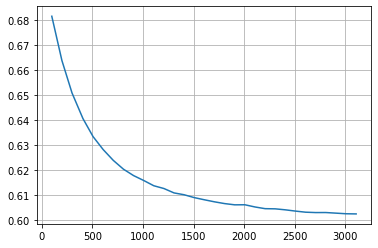

0.004701199437258765


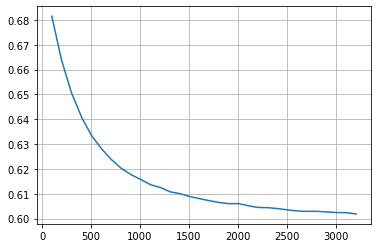

0.004130966168595478


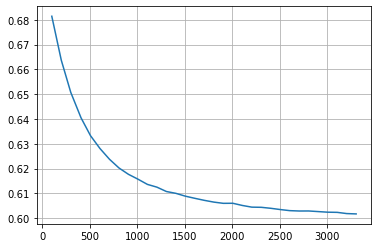

0.004446066797536332


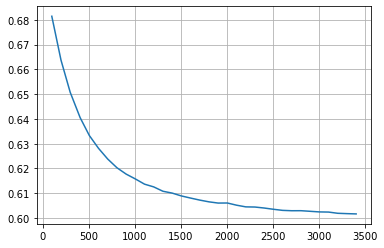

0.004214017295162194


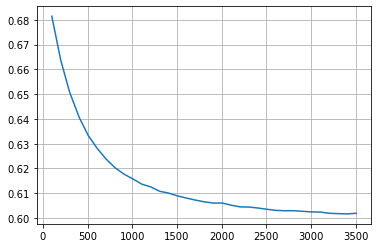

0.004259611258894438


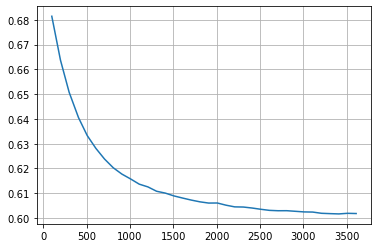

0.004518171661766246


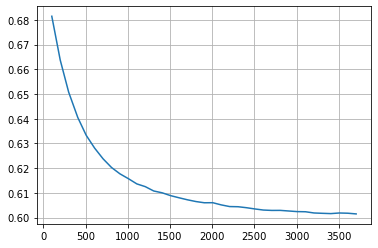

0.004445784683630336


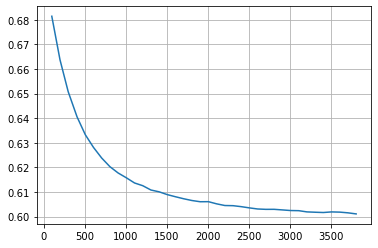

0.004023235713539179


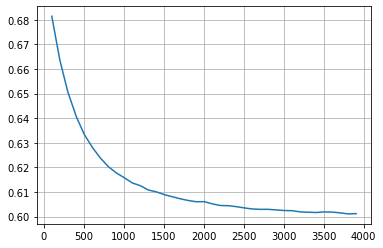

0.004217195331293624


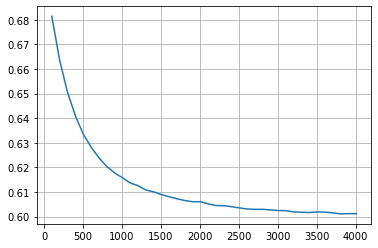

0.004402915354003199


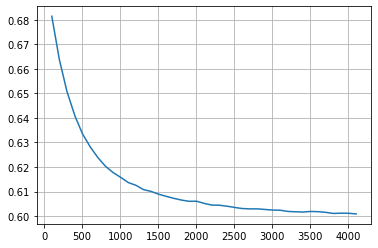

0.004040405518608168


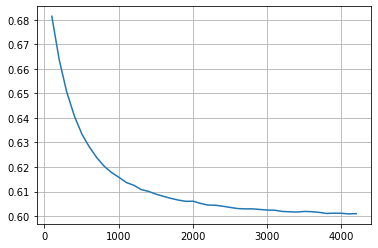

0.0038712889279122462


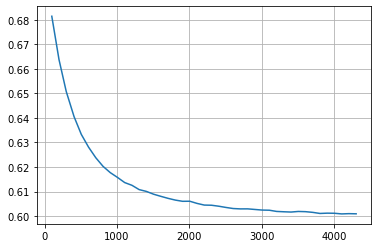

0.004226053805614356


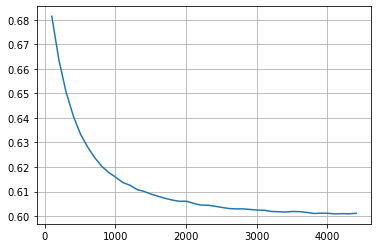

0.003755068359896541


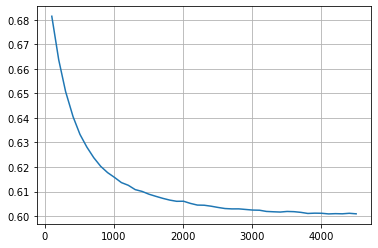

0.004061400380742271


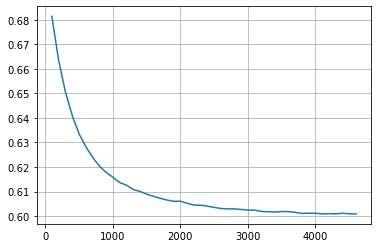

0.0038024645685800352


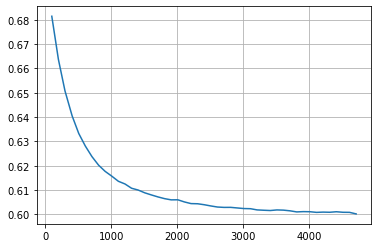

0.00373347447544802


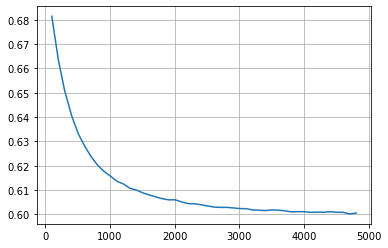

0.0037552507914369927


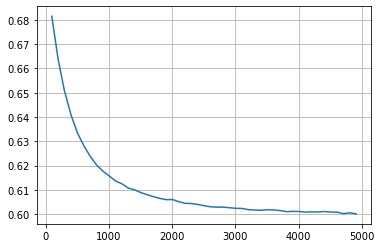

0.003470046600559726


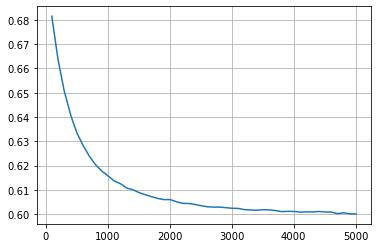

0.0037767016723228154


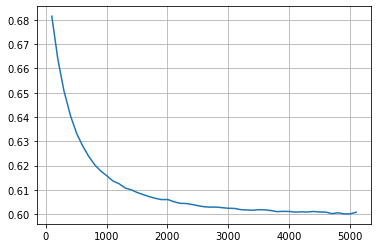

0.003838815194030758


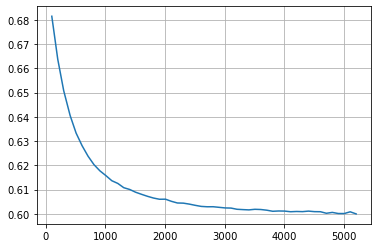

0.003585984735109378


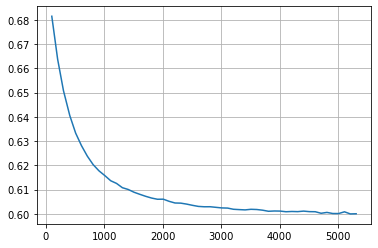

0.003551646898558829


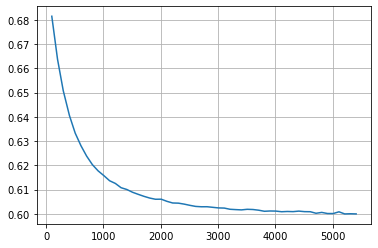

0.0035054273545392788


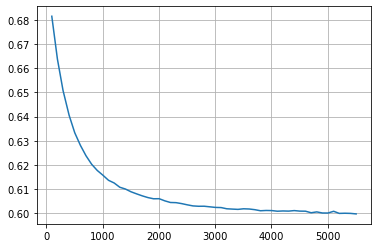

0.003370470661466243


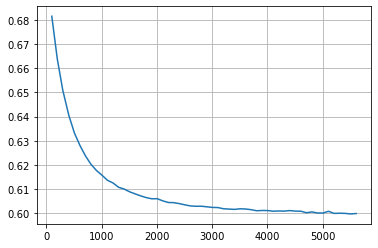

0.0034375116878072732


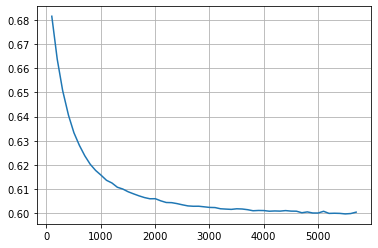

0.003498008590540849


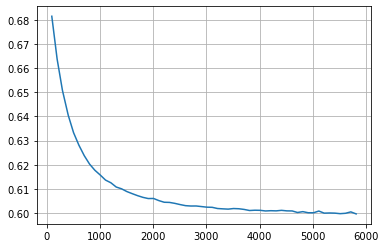

0.0032441481671412475


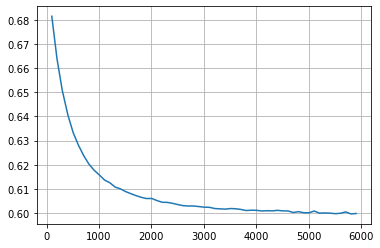

0.0033958161450573245


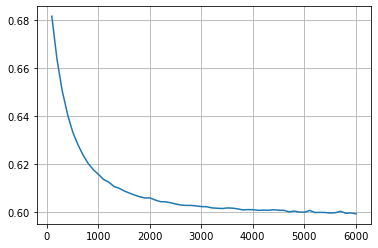

0.0033154800266493112


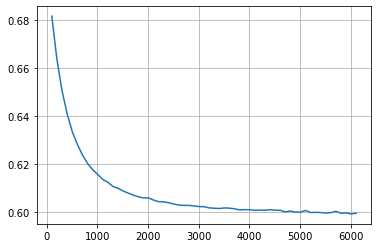

0.0036157913522038144


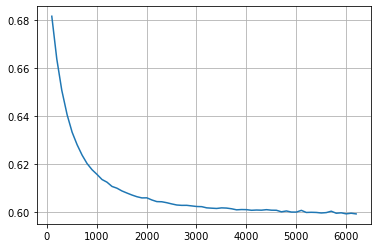

0.0034225855467957447


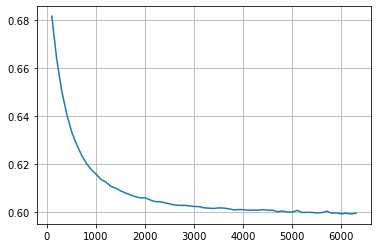

0.003086963956884574


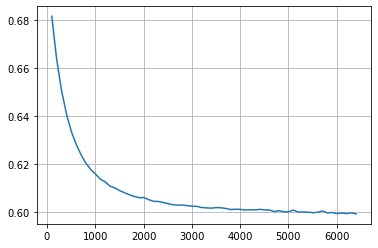

0.0031892237361171283


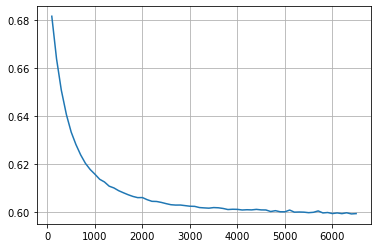

0.00316752855113009


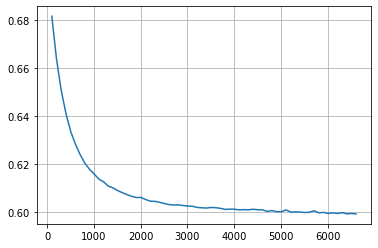

0.0032999102395842783


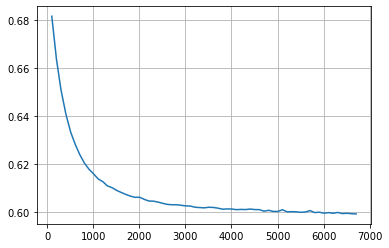

0.0031158210302237423


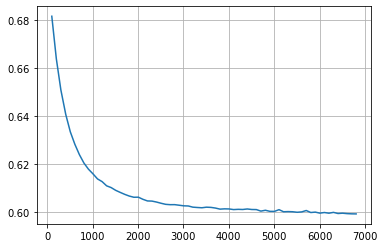

0.0032254015168291517


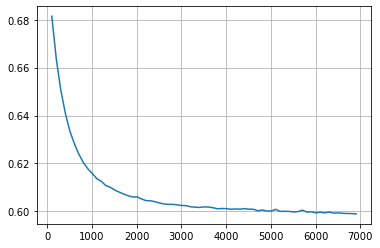

0.0032229170089703983


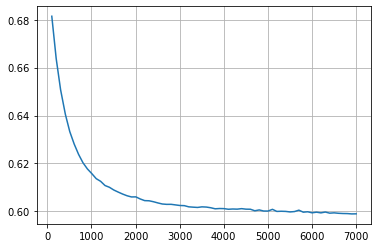

0.0033227439218899233


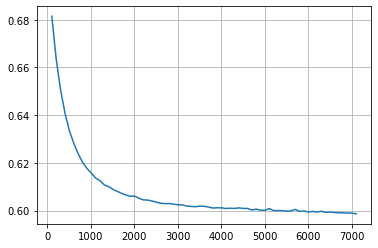

0.0034813640141510404


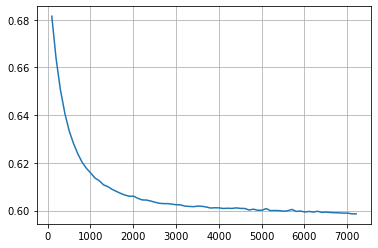

0.0034364205313613637


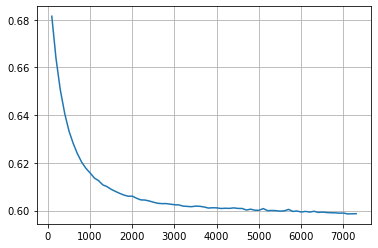

0.003326399580400903


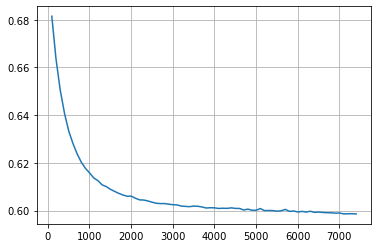

0.0034595863198046573


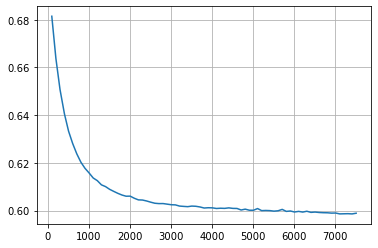

0.003189051750814542


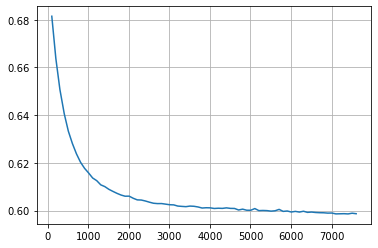

0.003409527171170339


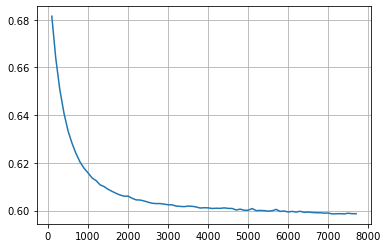

0.003303877950529568


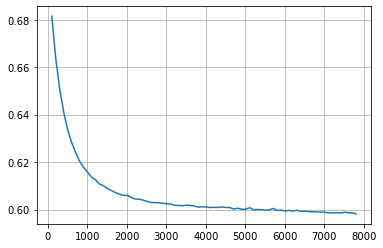

0.0034554718196159228


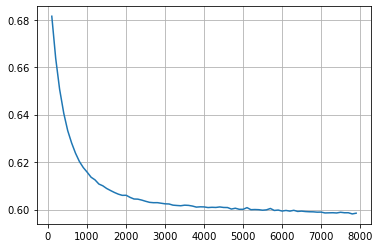

0.003256138869037386


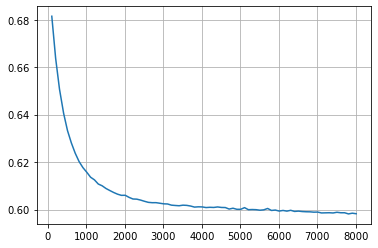

0.0032197904639178886


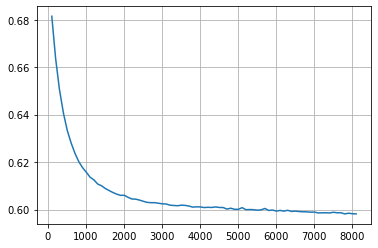

0.003009595917537808


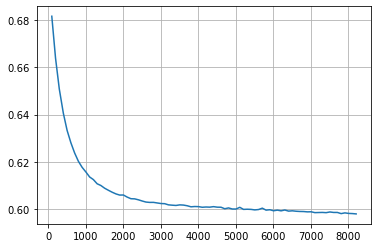

0.0033814141538459808


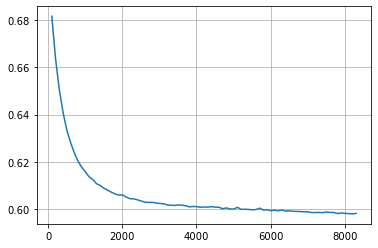

0.0032267284084809946


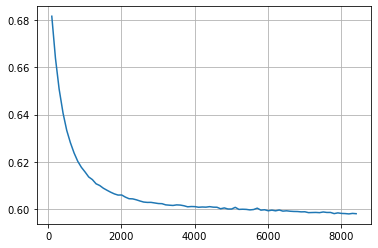

0.003111240672005806


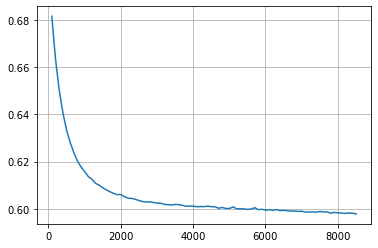

0.00320552286459133


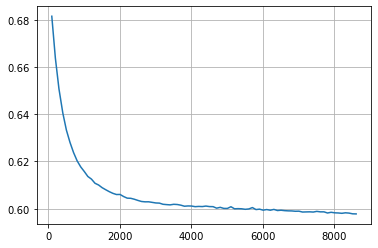

0.003056789014081005


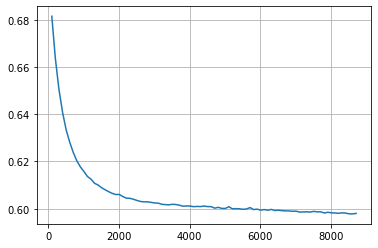

0.003369822534150444


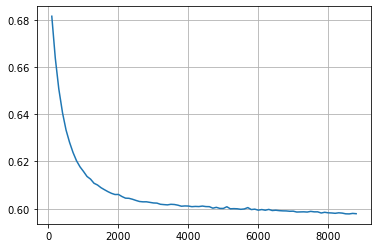

0.003019745104247704


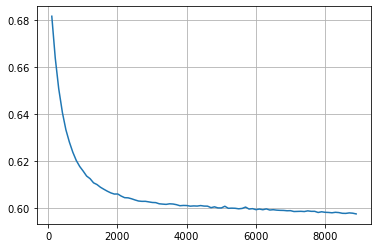

0.003063013169448823


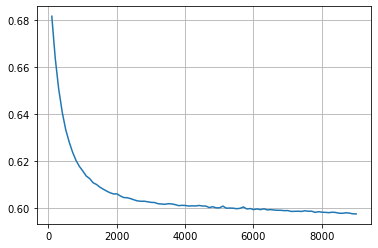

0.0030622206279076634


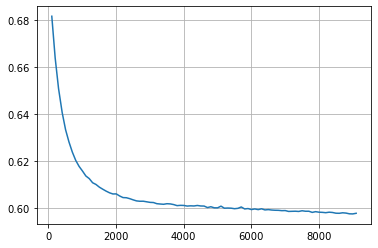

0.0030460563985980115


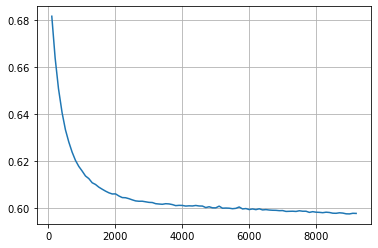

0.0033875758506474087


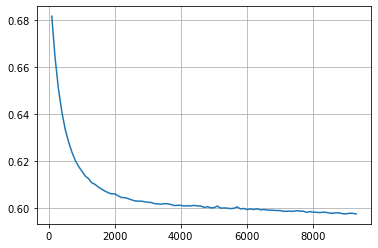

0.003177237402123865


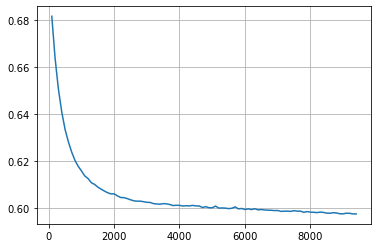

0.0031475081923417747


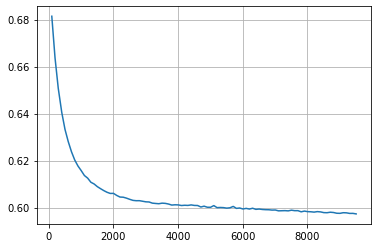

0.0031403246201807634


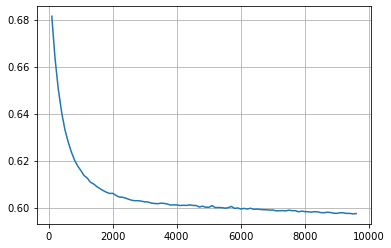

0.00335019328573253


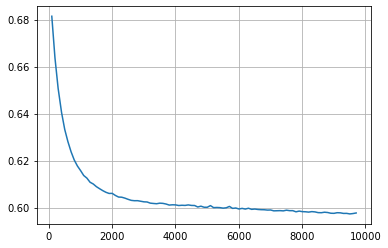

0.0030192843967233787


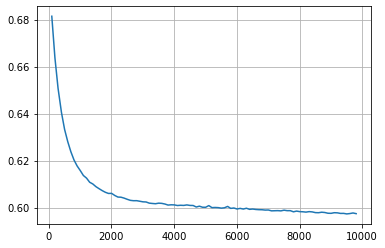

0.0031200599766452795


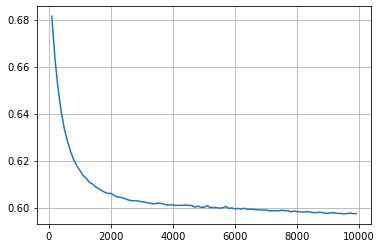

0.0031167780893156306


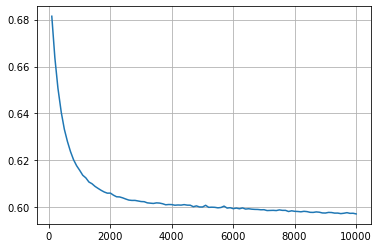

0.0030217319852090443


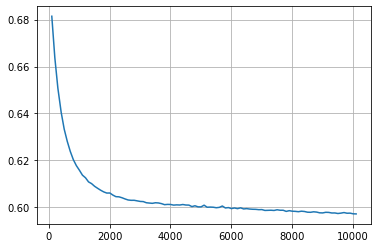

0.0031644497253000736


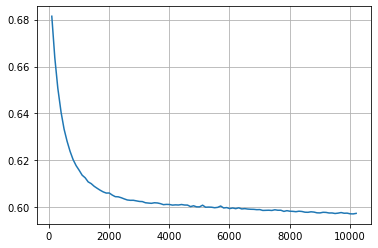

0.0031246450234903023


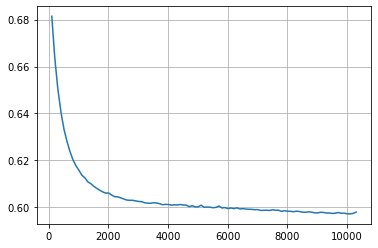

0.0029552118355059063


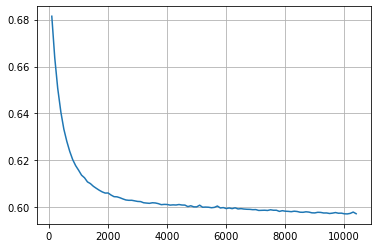

0.0031059233465930446


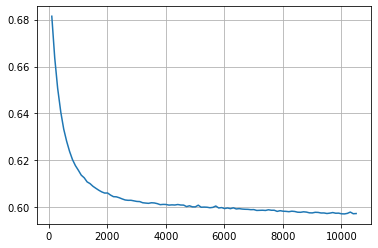

0.0028444600774673746


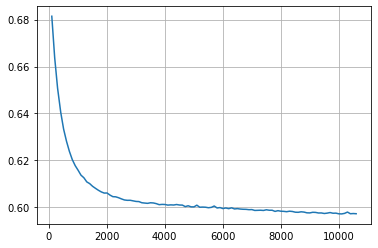

0.0033396437016199342


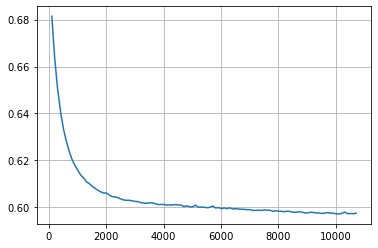

0.0031306493806187064


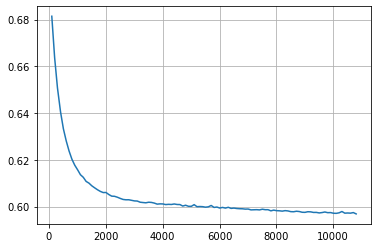

0.0032353490678360686


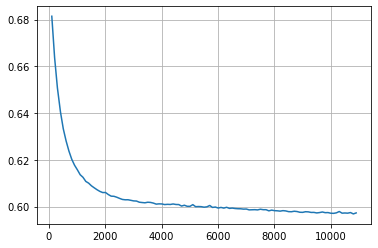

0.0027913778385845944


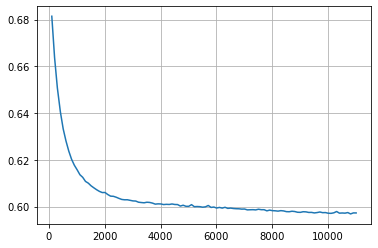

0.0028574354355805553


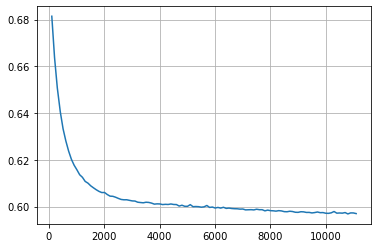

0.0029530956139205955


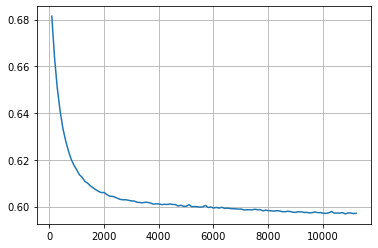

0.0030877873295685277


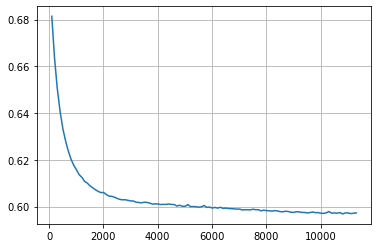

0.002956059736607131


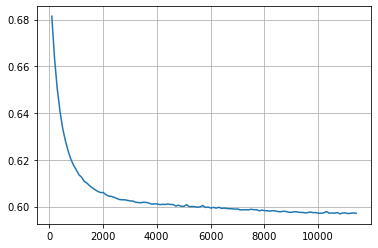

0.0029064694119733756


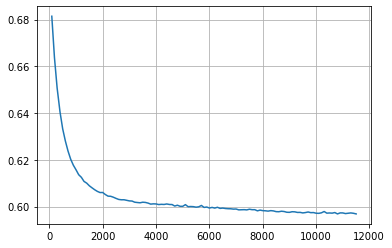

0.0029774435621220618


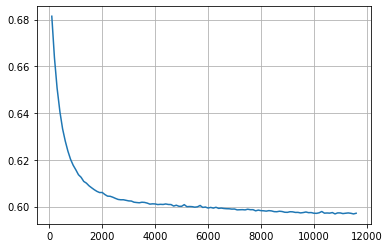

0.0028186646141693927


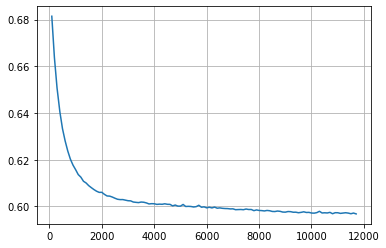

0.0029862883387249896


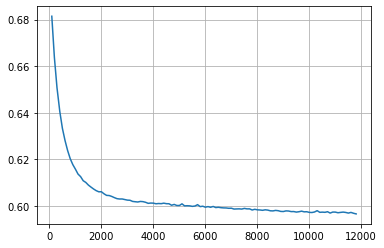

0.0028806921298382806


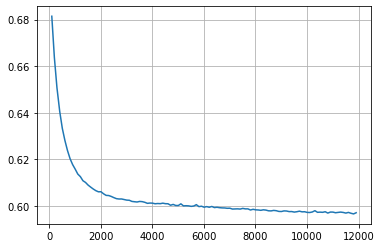

0.0027773001661989837


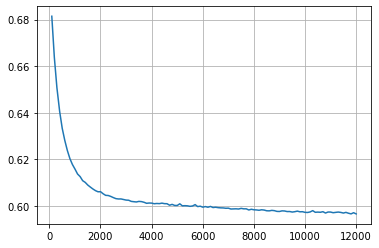

0.0028619043951039203


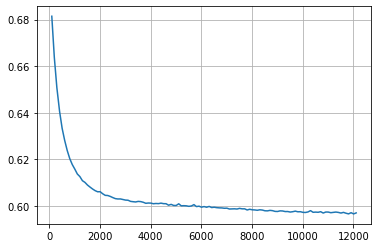

0.003056100734975189


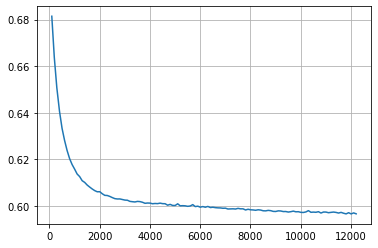

0.0029020906990626827


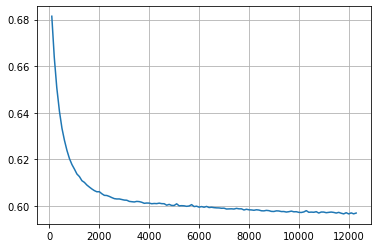

0.0027612991421483457


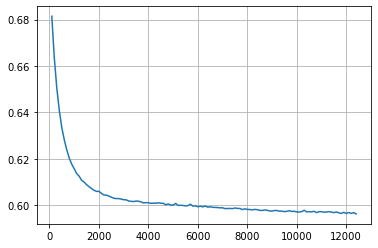

0.002814804402878508


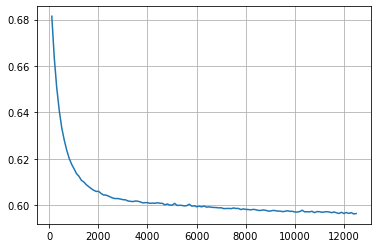

0.0030824033339740707


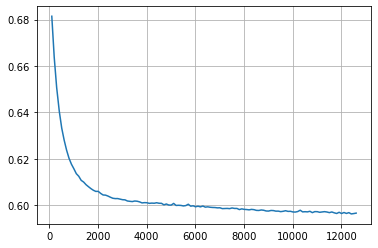

0.0029631122713908555


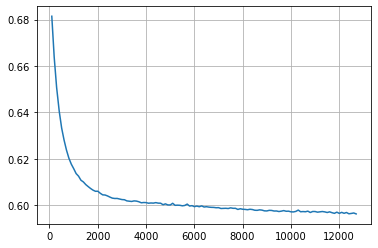

0.0025687220189138317


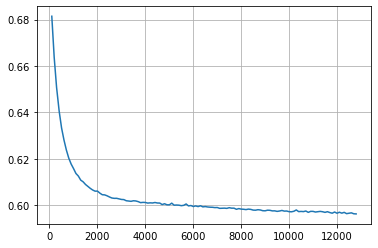

0.002983113723748829


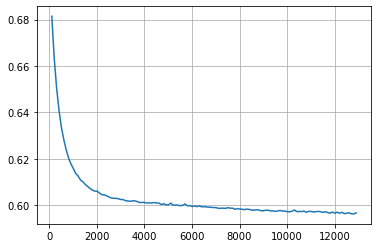

0.002777649250347167


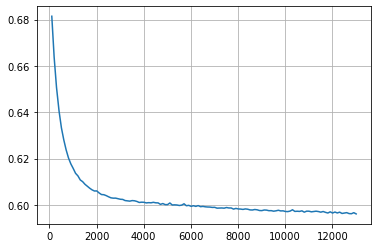

0.0030056144506670534


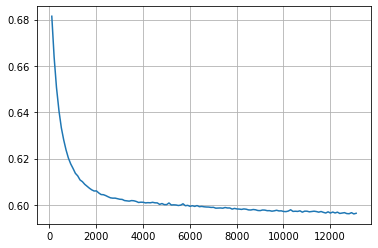

0.002797579004254658


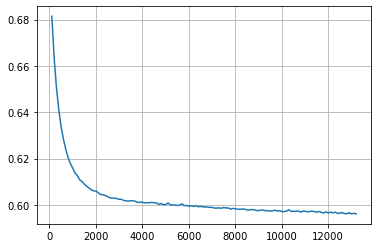

0.0030018171173287556


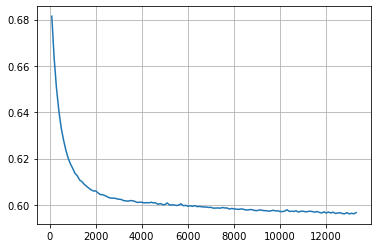

0.0030543623643461615


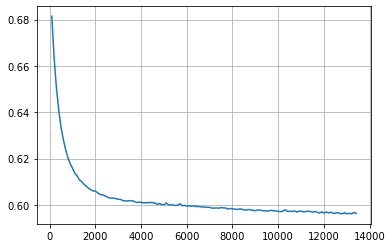

0.002702854686358478


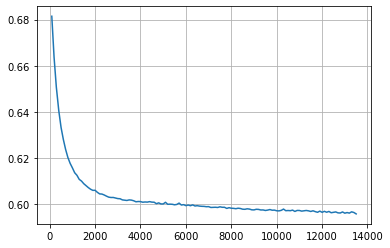

0.0027958064593258313


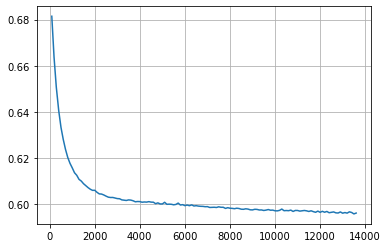

0.002956502869783435


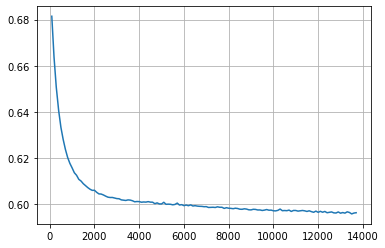

0.0025779859814792873


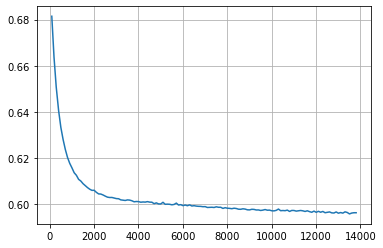

0.0027041350831859745


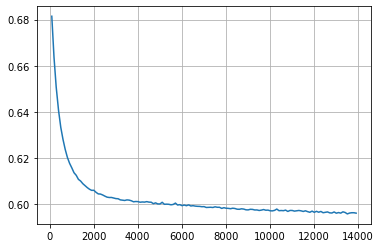

0.002702734256745316


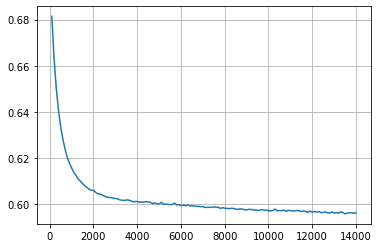

0.003002365149150137


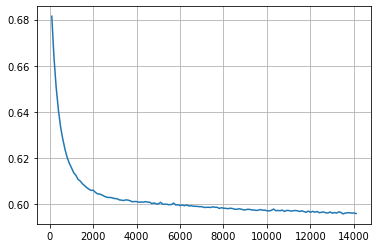

0.0028196826824569143


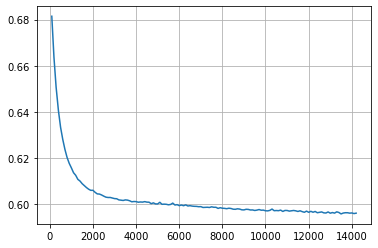

0.002757156198786106


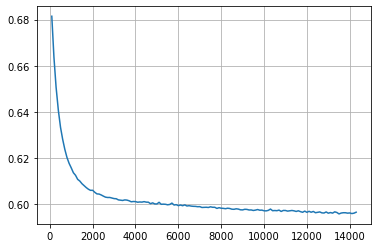

0.002886037914431654


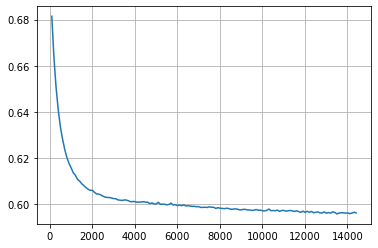

0.0029353060736320912


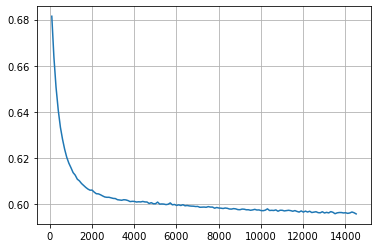

0.0030736335966503247


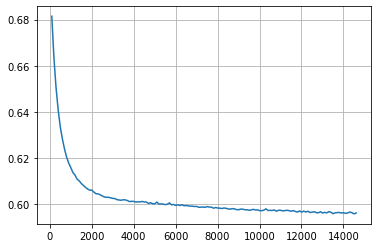

0.0027069438103353603


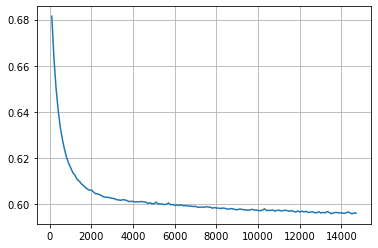

0.002775674241129309


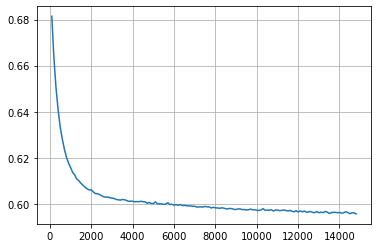

0.002808781083440408


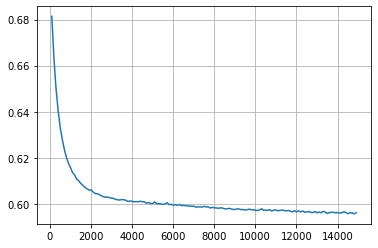

0.0027810013003181666


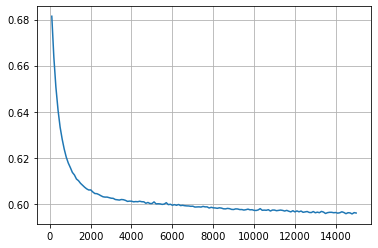

0.0029778974124928938


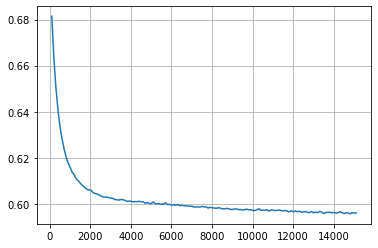

0.00284672729059821


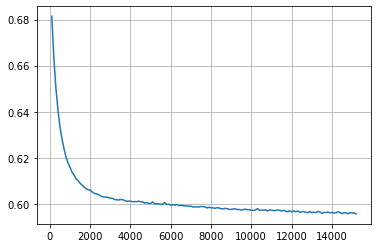

0.0026811620939406564


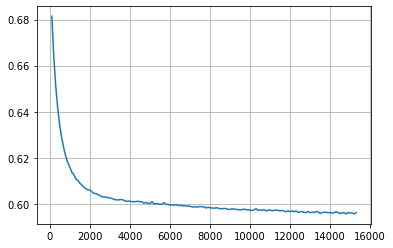

0.002704896964132786


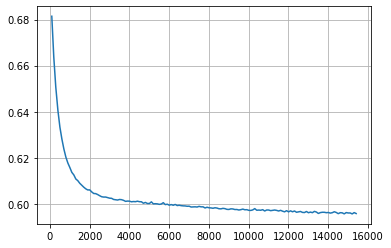

0.002938419322599657


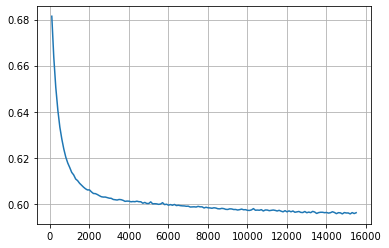

0.002921512413304299


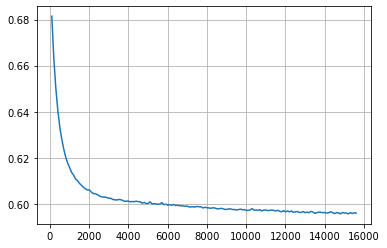

0.0029818080444238147


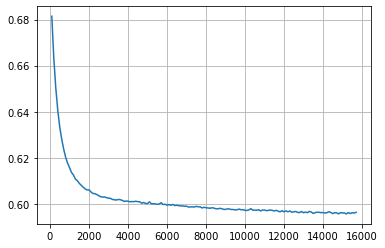

0.0026513815685757437


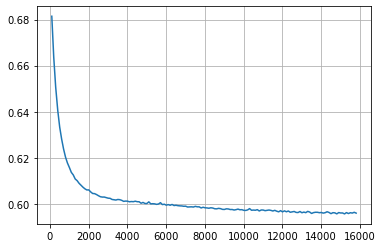

0.0027180903020780534


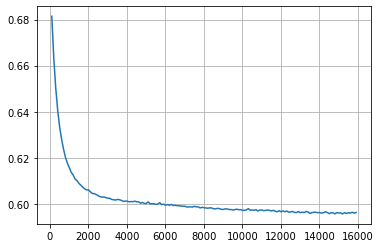

0.00269627662433777


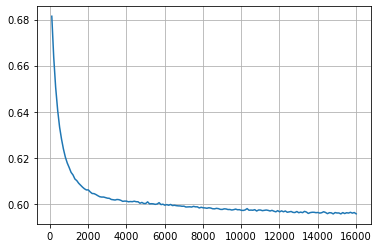

0.0028343278862303124


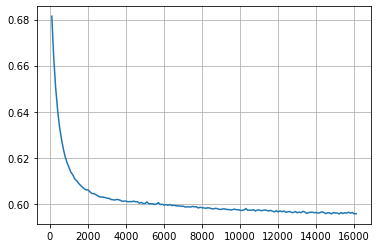

0.002982031228020787


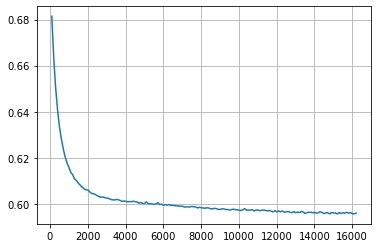

0.002908247656887397


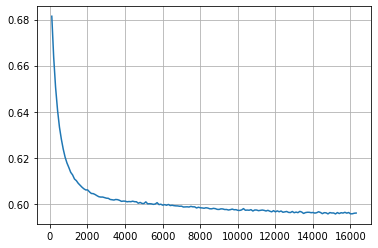

0.0028951109346235173


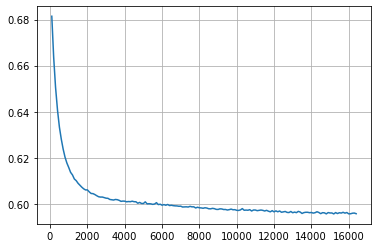

0.0028995289641898124


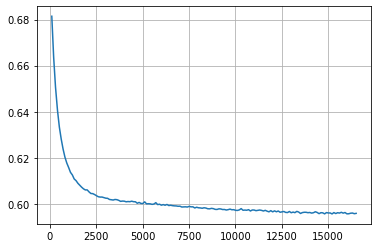

0.002721967456745915


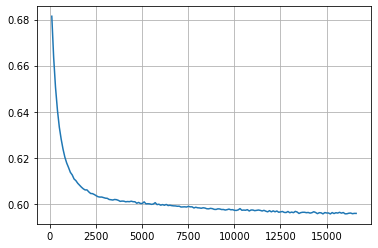

0.0026964468660298736


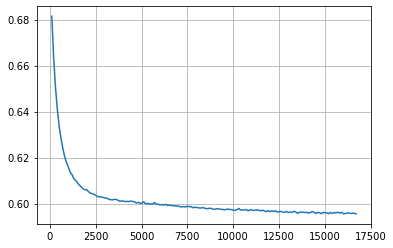

0.002617654032073915


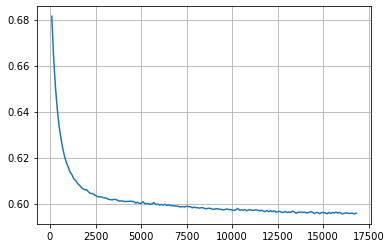

0.002570113278343342


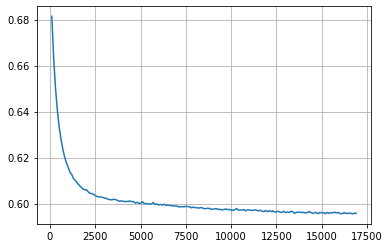

0.0028782378701725977


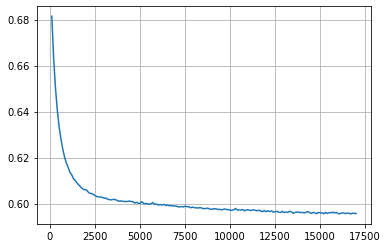

0.0026756630116142334


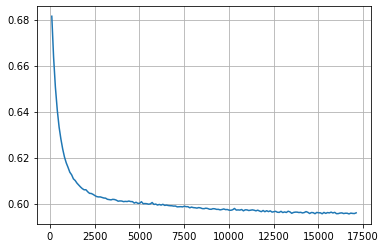

0.0025653011313988825


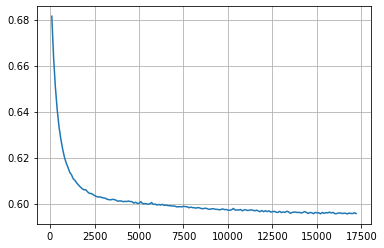

0.0027993535896530374


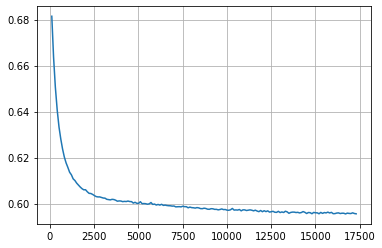

0.0026360808187746443


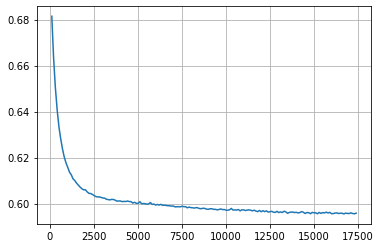

0.002662956054555252


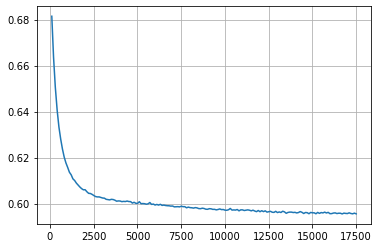

0.0027738366211997345


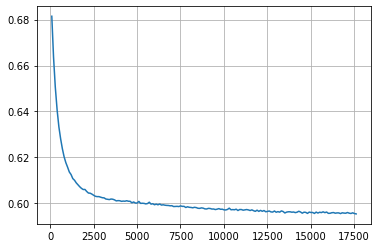

0.0027471625106409193


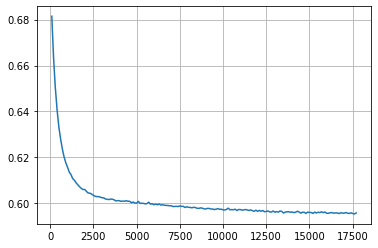

0.0025720861274749042


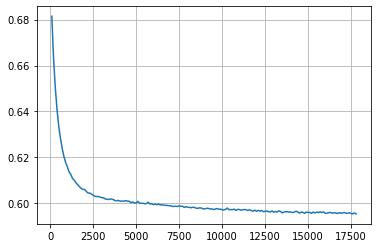

0.002819235678180121


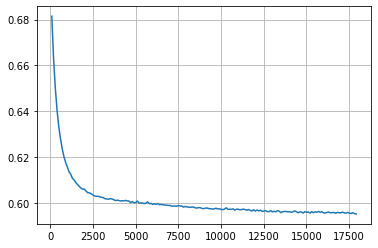

0.002703703687293455


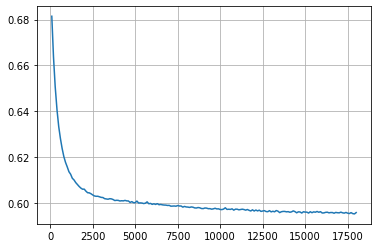

0.0029255396011285484


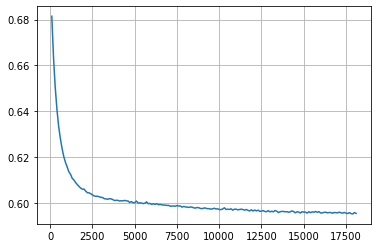

0.002721632916654926


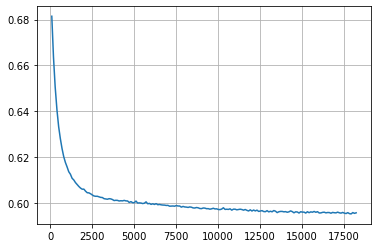

0.00256663276522886


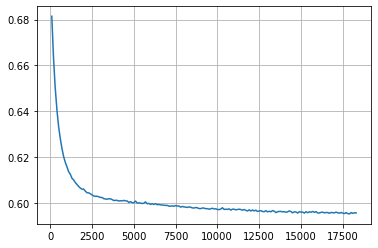

0.002728547414008062


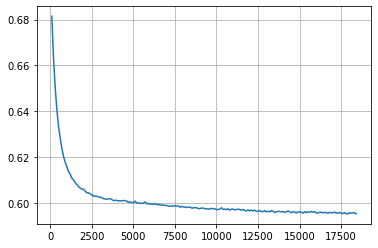

0.0026838375849183647


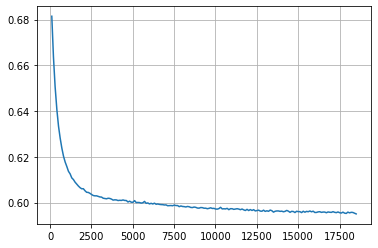

0.0027036107453750446


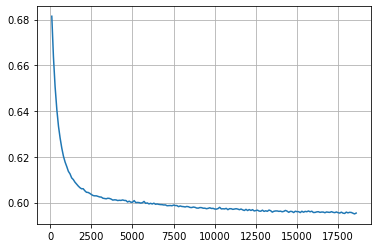

0.002546125095395837


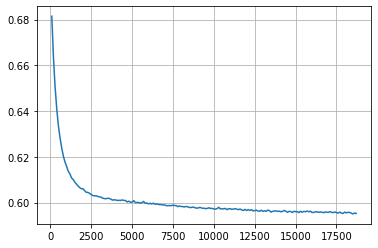

0.0027534138300688935


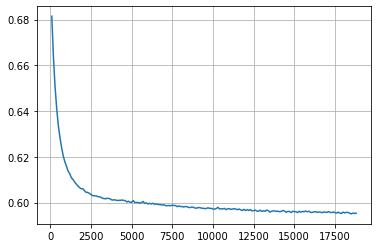

0.002681377911940217


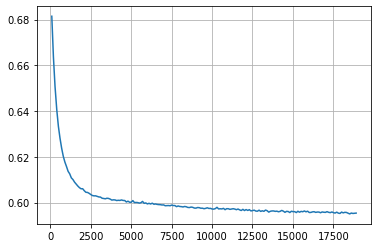

0.0024859799526166172


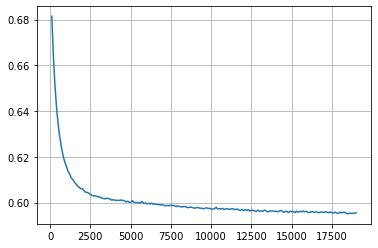

0.0024452638591174036


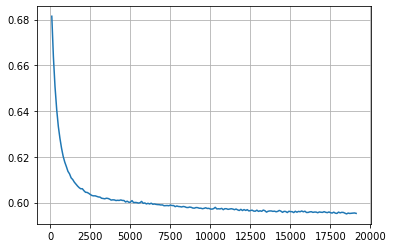

0.0023581634816946463


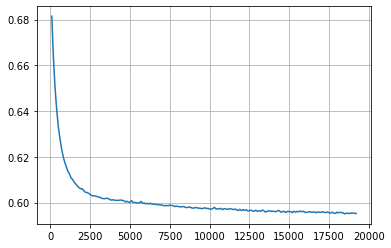

0.0025140724537777714


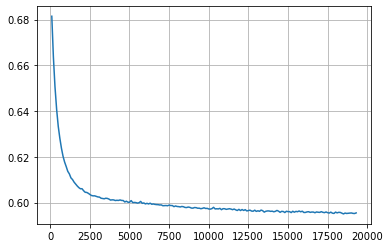

0.002645109139266424


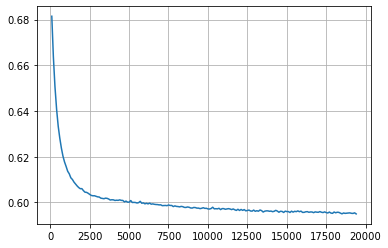

0.002548479142715223


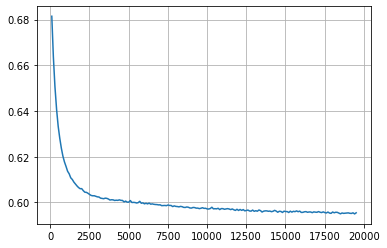

0.0026046881411457435


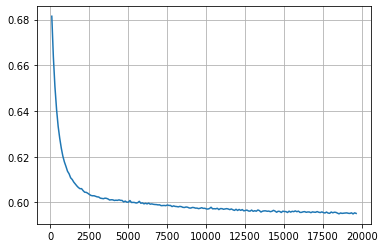

0.002712131795415189


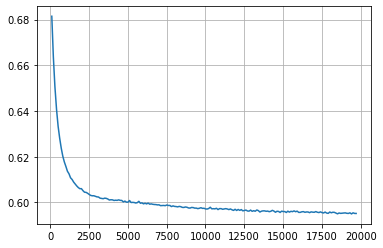

0.0027332243358250707


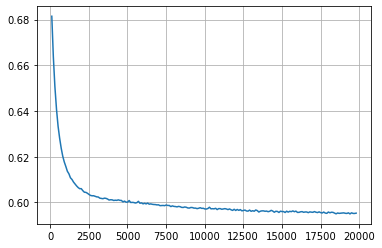

0.0026372922089649363


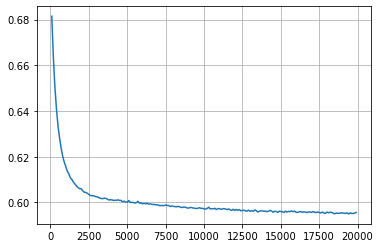

0.002504611314216163


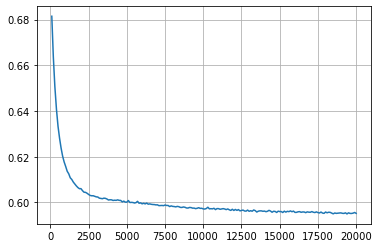

0.002434749735402875


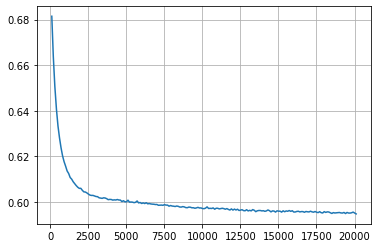

0.002683601556054782


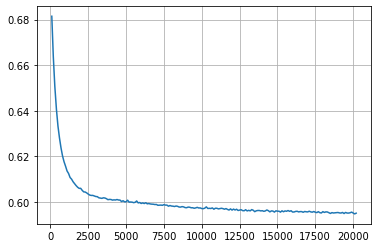

0.002564296756754629


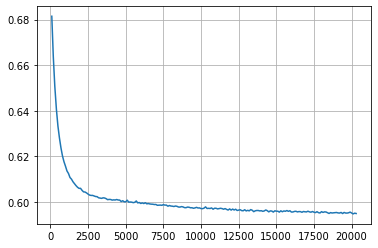

0.0024085528691648508


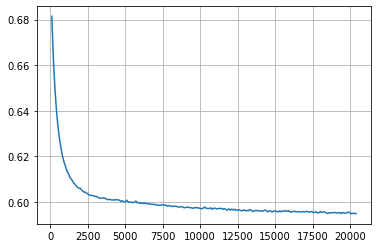

0.0024797239663894286


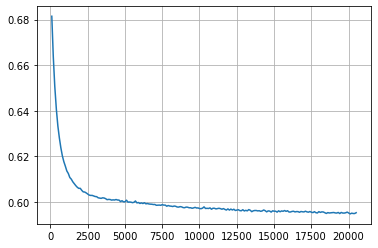

0.002422397629125044


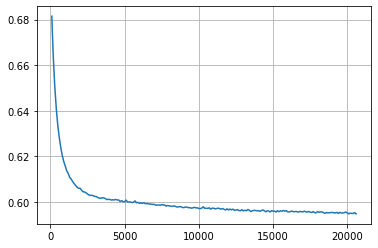

0.002538099709781818


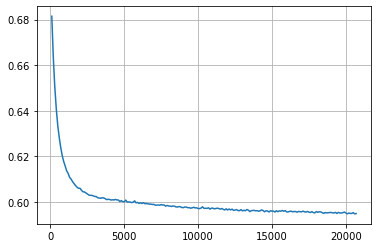

0.0026875153346918525


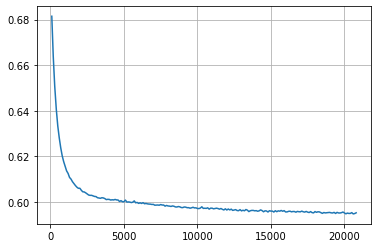

0.002647342960117385


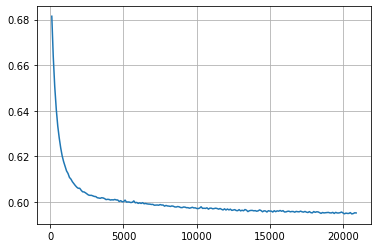

0.002423372520133853


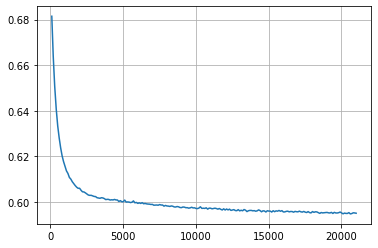

0.0024988804652821273


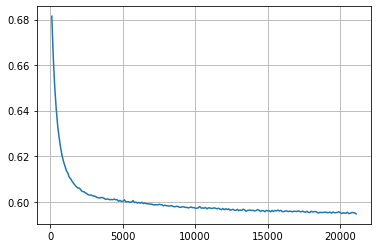

0.002419758430623915


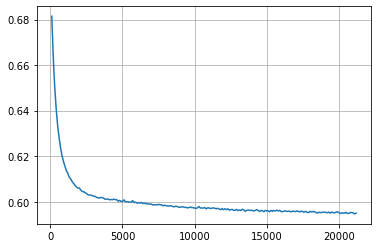

0.002667048705043271


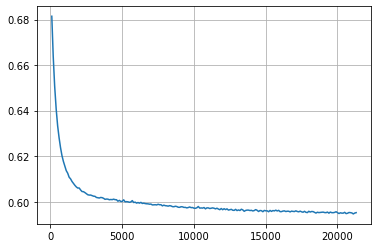

0.002628088517813012


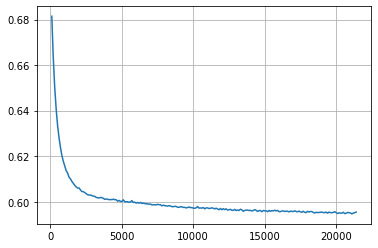

0.0023407763201976194


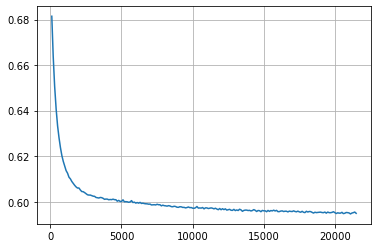

0.0024753041693475098


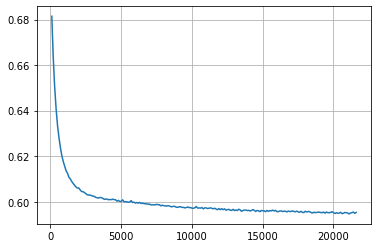

0.0024948266529827377


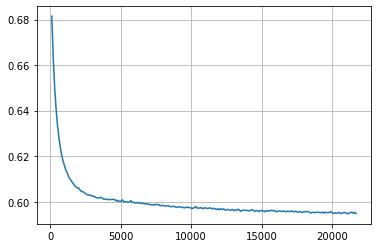

0.00252508487959858


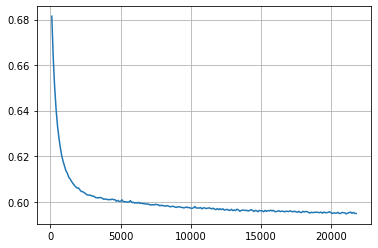

0.002456612665846478


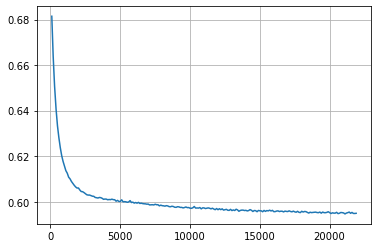

0.0025688176974654198


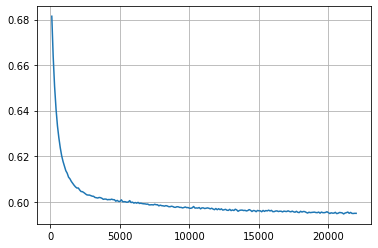

0.002444728204573039


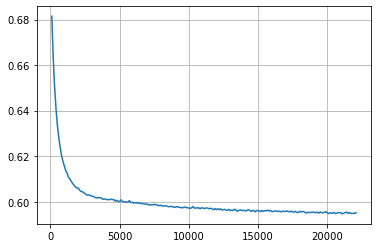

0.0025312258367193863


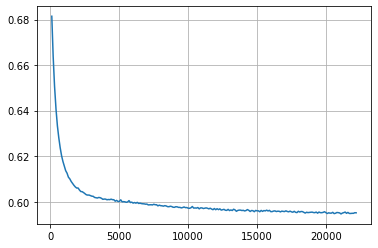

0.0026500711712287737


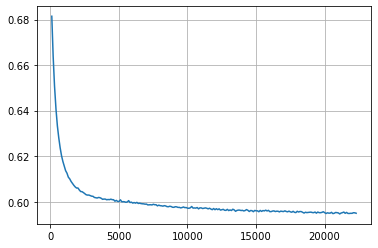

0.0025547521206317468


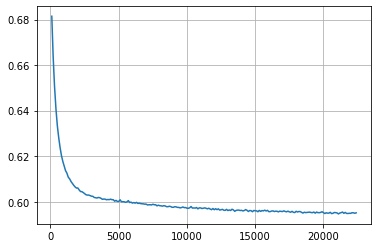

0.002431640134891495


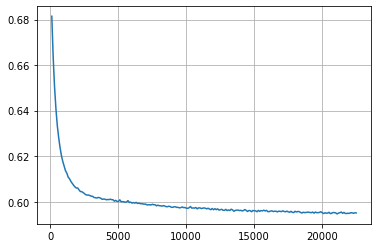

0.00255086072254926


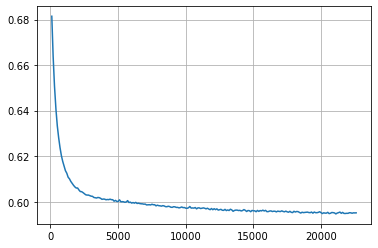

0.002698265794024337


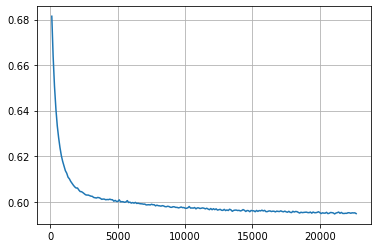

0.0026128202490508555


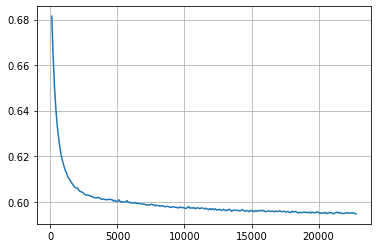

0.0025763279950479045


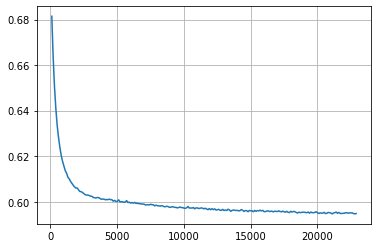

0.0024074184393975883


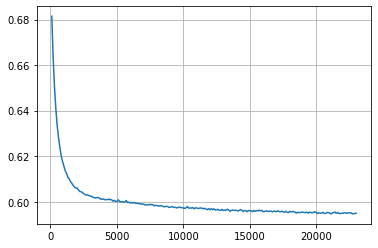

0.0027437057945644485


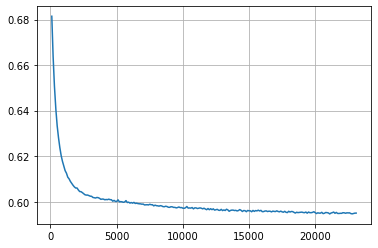

0.002405301462858915


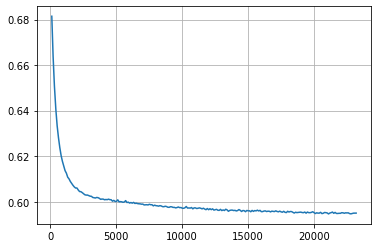

0.0027414588726242073


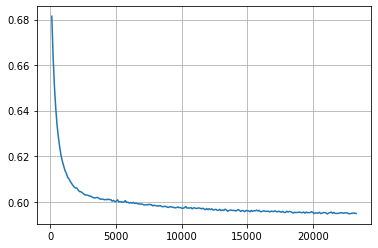

0.0028067856872803533


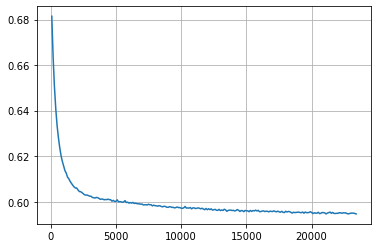

0.002672124683158472


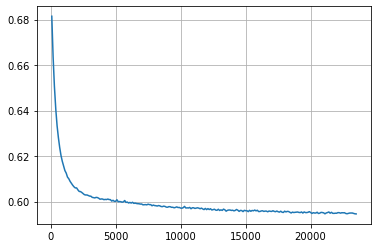

0.0025548796425573527


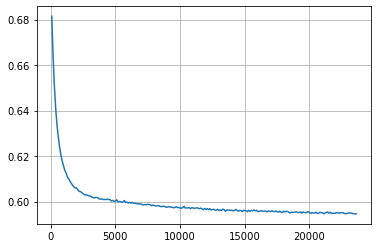

0.0026236288467771374


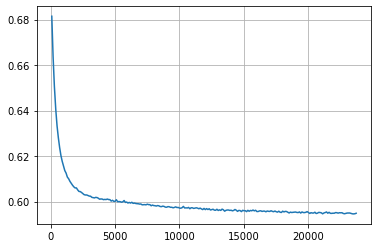

0.0026546446498832664


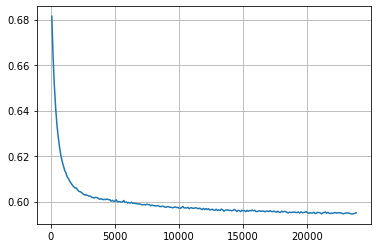

0.0028529601549962536


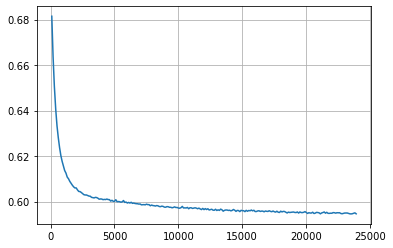

0.002735384591505863


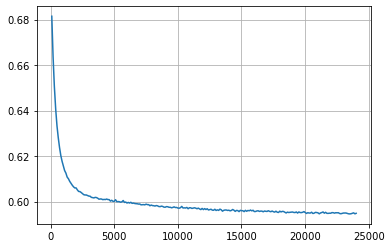

0.002822816025291104


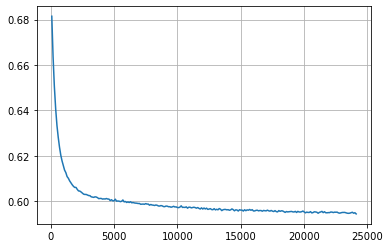

0.002469961452879943


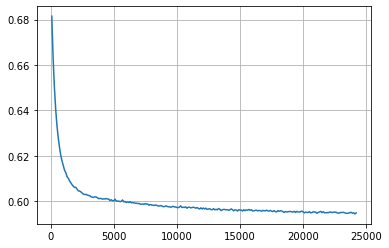

0.002897185786277987


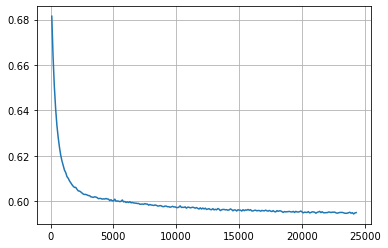

0.002641405333997682


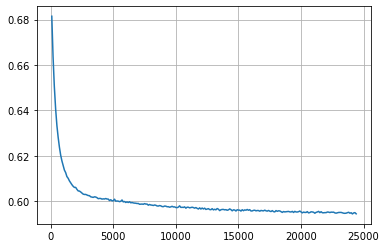

0.0028459027269855143


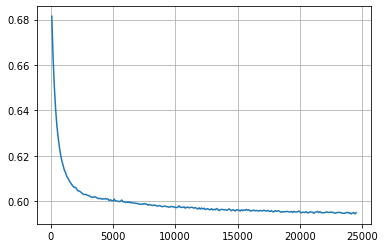

0.0033081279962789267


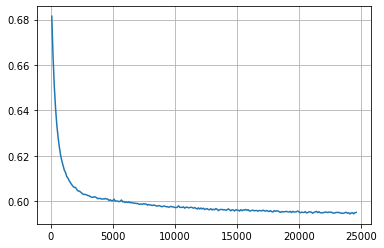

0.0023018809233326465


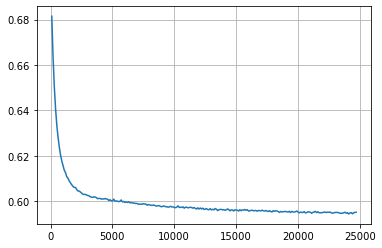

0.002734142952831462


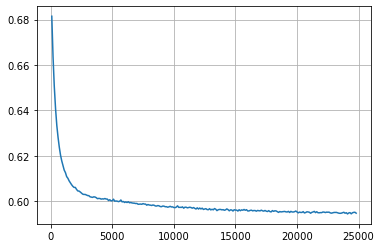

0.0026292741787619887


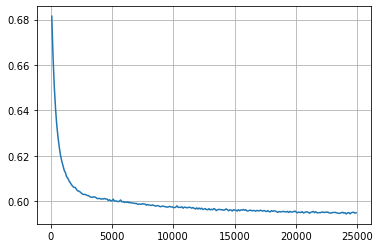

0.0025341403609490955


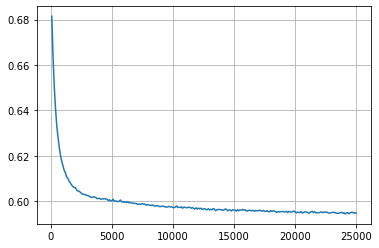

0.002855093703547027


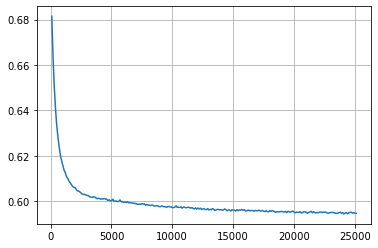

0.0028270542342215777


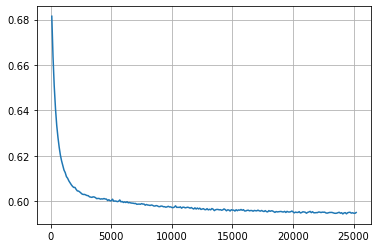

0.002584206633910071


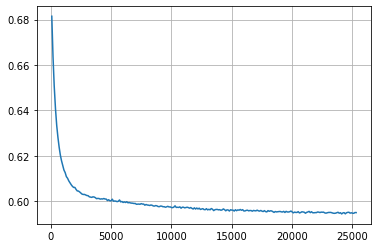

0.0028675094177015126


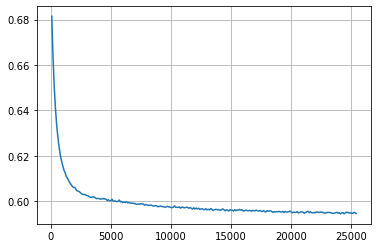

0.0024437320604920386


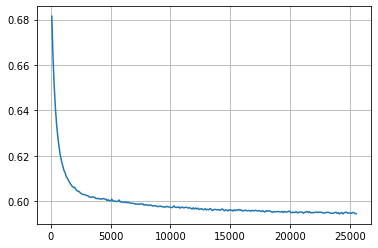

0.002690612963051535


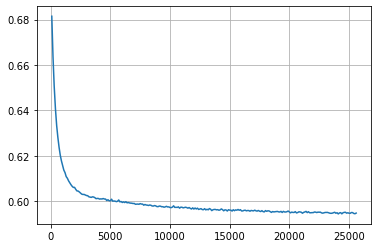

0.0026147628456237725


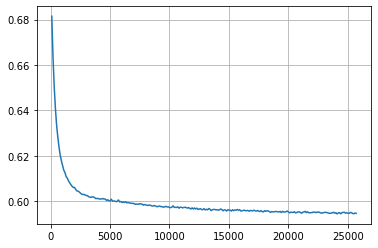

0.0026221159158740194


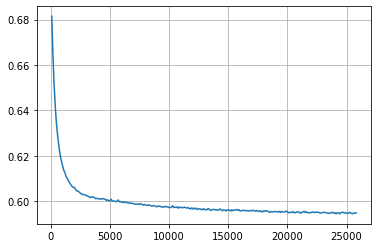

0.002437172430800274


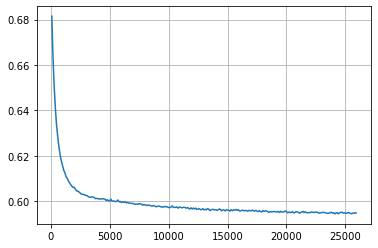

0.00271601349581033


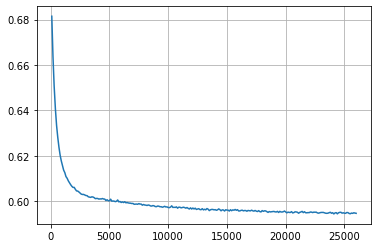

0.002878601207630709


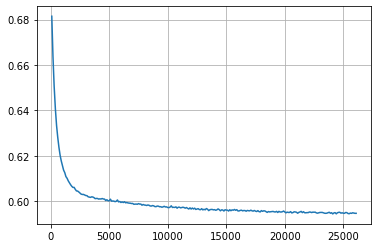

0.002553654650691897


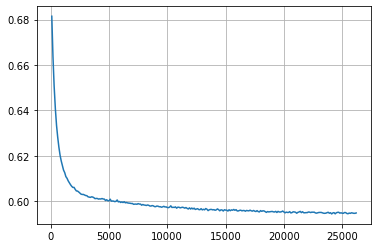

0.0026084702392108737


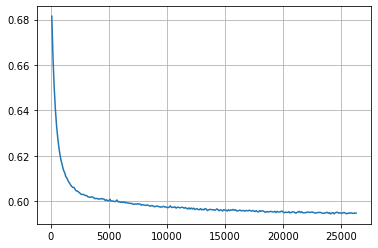

0.002678049858950544


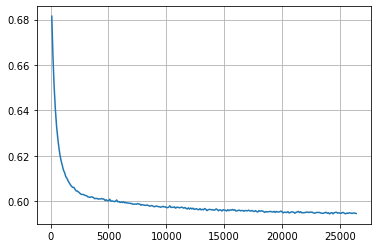

0.003034582670661621


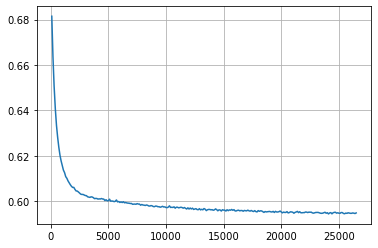

0.002696239426149987


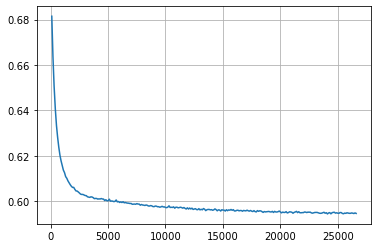

0.002248405028949492


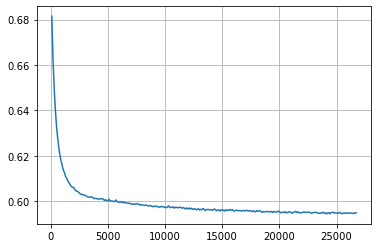

0.002572521822876297


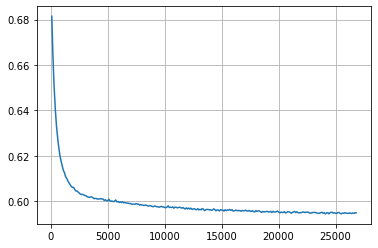

0.0025319207418942826


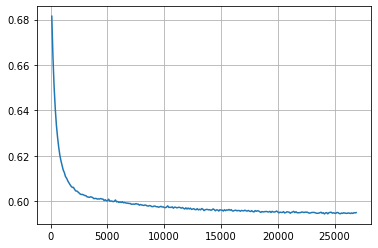

0.002690112879499793


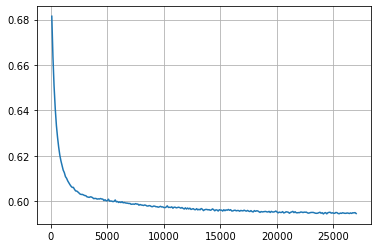

0.0021335926867322996


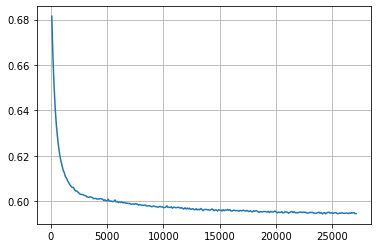

0.002397838768083602


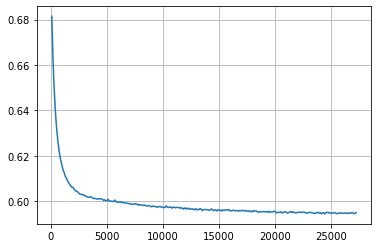

0.0022432329034199937


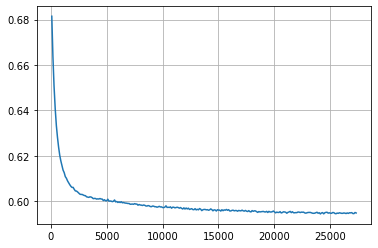

0.002461604502750561


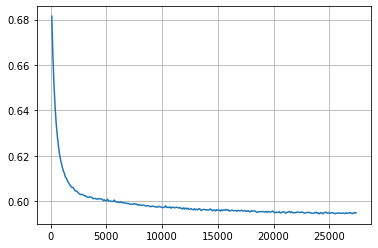

0.0024527450784808027


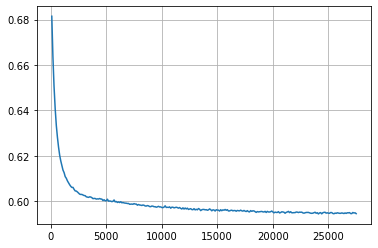

0.0023361320709227584


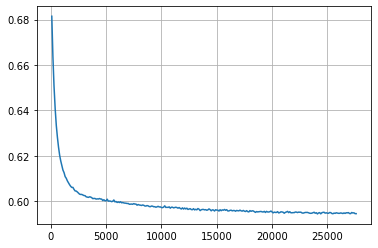

0.002286305555317085


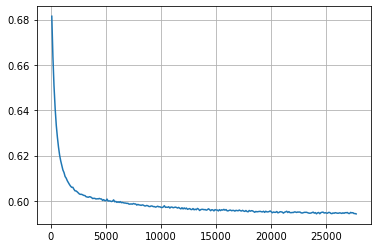

0.0022070798196364193


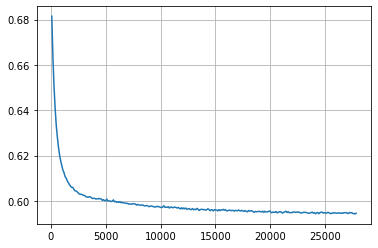

0.002390326801396441


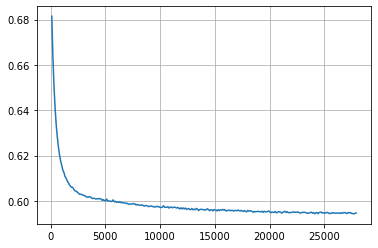

0.0023419392443611285


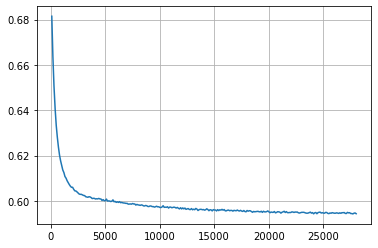

0.0024155525007518008


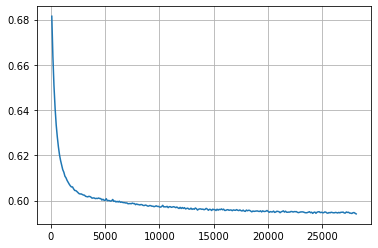

0.002631855918443762


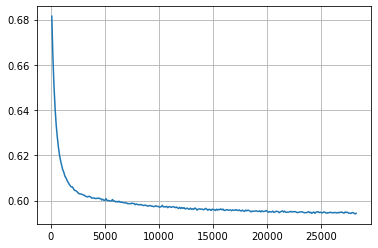

0.0027161002665525304


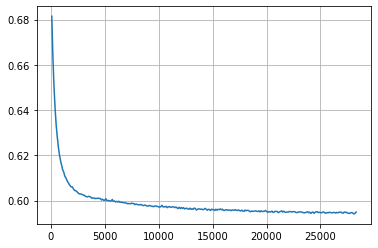

0.002528214058256708


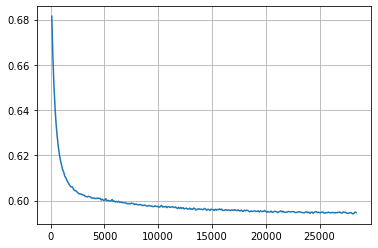

0.002320064281520899


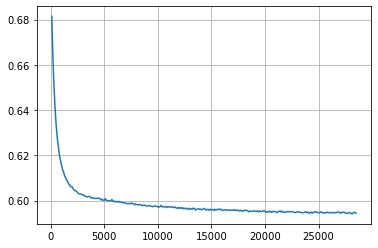

0.002168042947596405


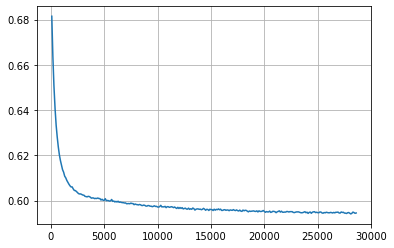

0.00219935164146591


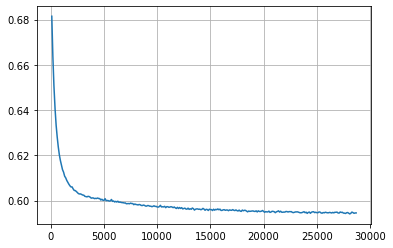

0.002271942690713331


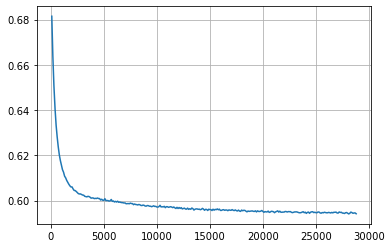

0.0022606602479936554


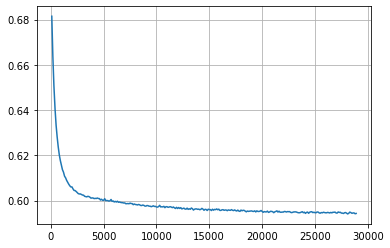

0.002038817556167487


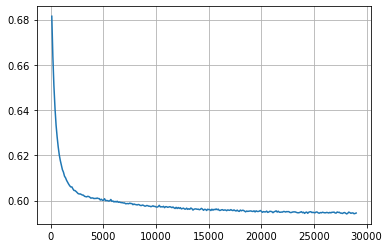

0.0021712946037587243


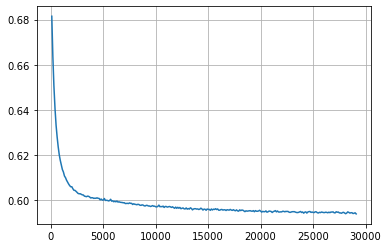

0.0020420992834260685


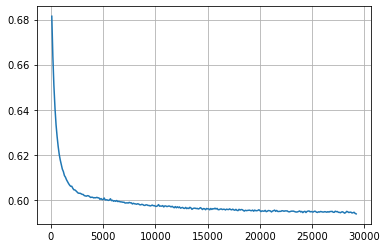

0.0020484280490200035


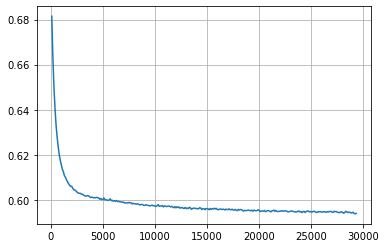

0.0023909277317579834


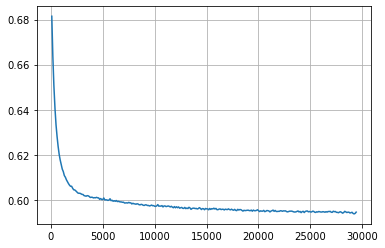

0.002360452273860574


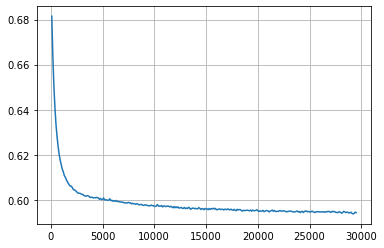

0.0025119246676331385


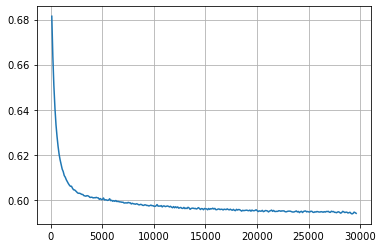

0.0023042640328640117


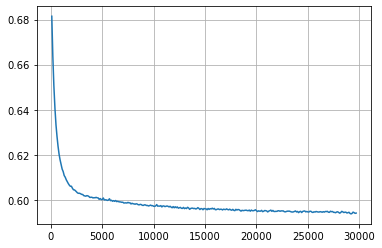

0.0024162719087325968


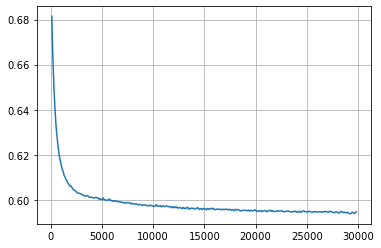

0.0018496287605375983


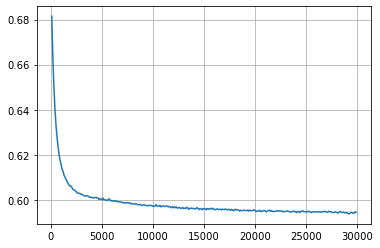

0.0020852612267481165


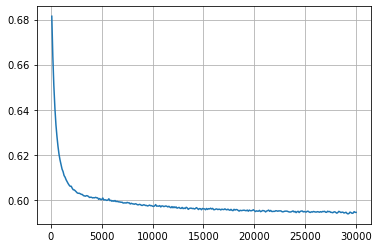

0.001926302507345099


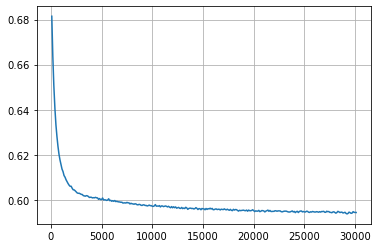

0.0023389080940978604


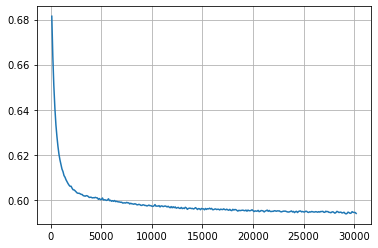

0.002167211813793983


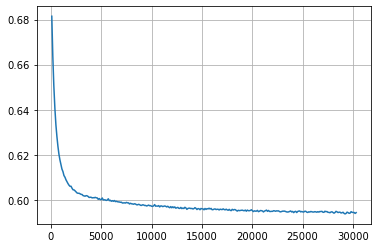

0.0020210969034815205


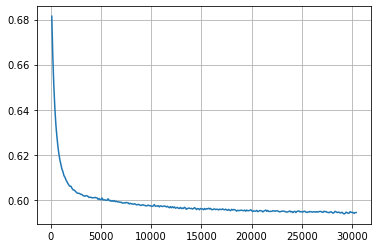

0.002177227040810976


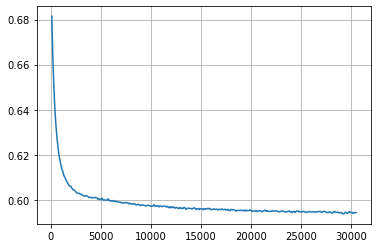

0.002310068928054534


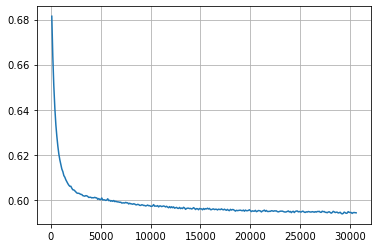

0.0024468046656693334


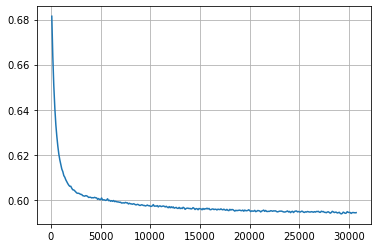

0.002412073170999065


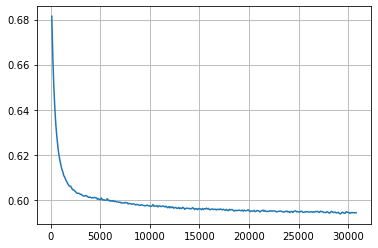

0.002022553944843821


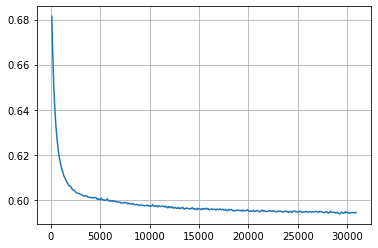

0.0020943396422080695


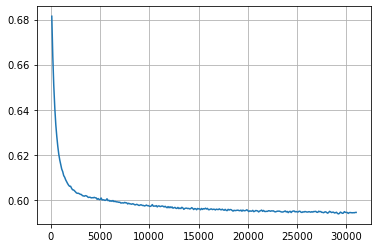

0.0020960640348494054


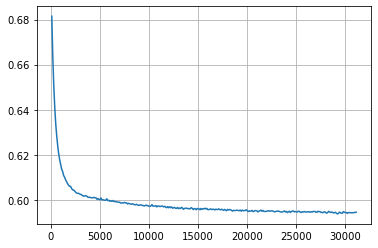

0.0021686648108880037


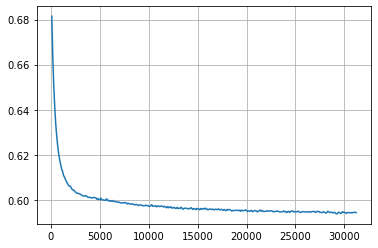

0.0025401398015674204


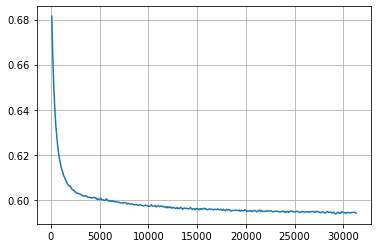

0.002148091650742572


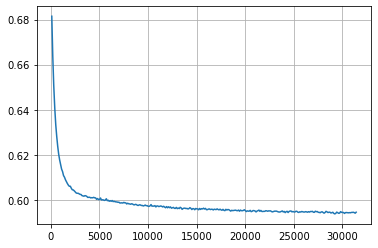

0.0019537873612716795


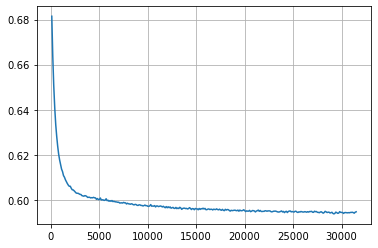

0.0018017568925279193


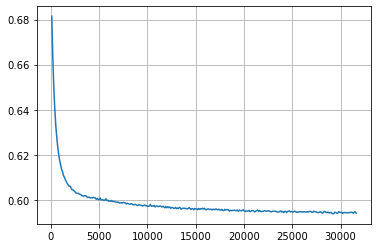

0.0017385377793107182


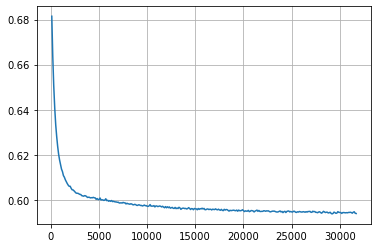

0.00189321922021918


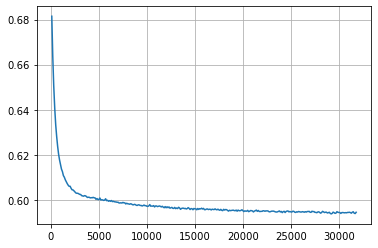

0.00200559859367786


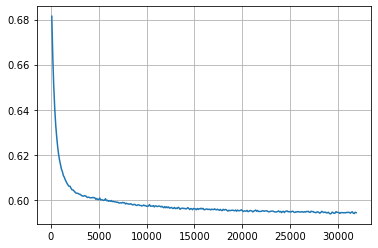

0.0022012275864835827


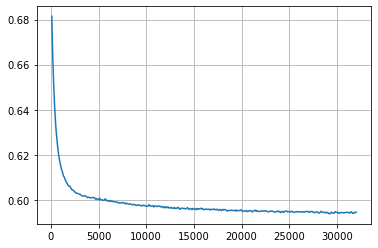

0.0019890969508560372


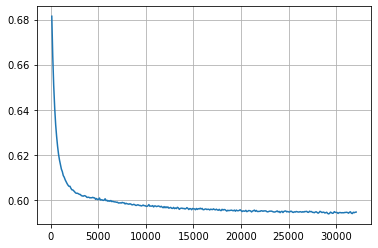

0.0021763809872209095


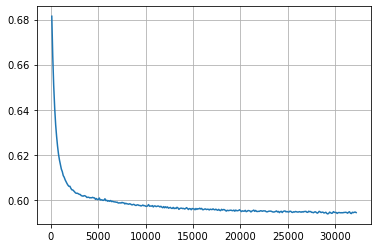

0.0024401350313564764


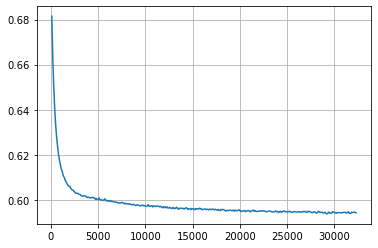

0.0017951820828602649


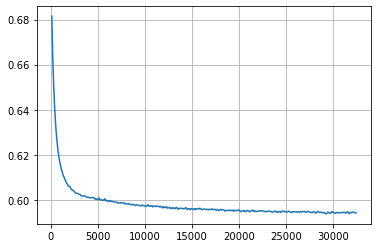

0.0022175287429126913


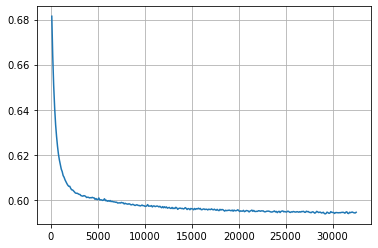

0.0021972756407922134


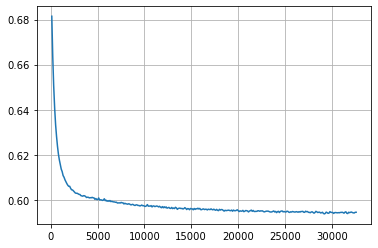

0.001963222608319484


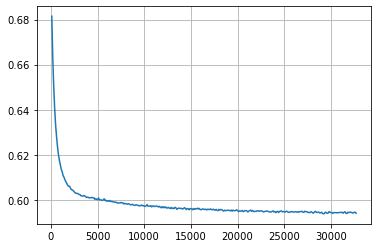

0.0017742956621805207


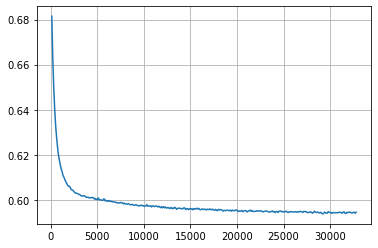

0.001924104389618151


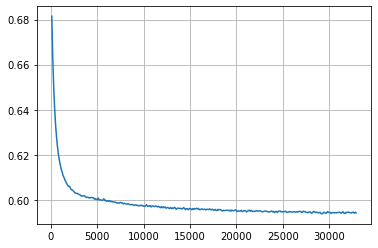

0.0023743889038451015


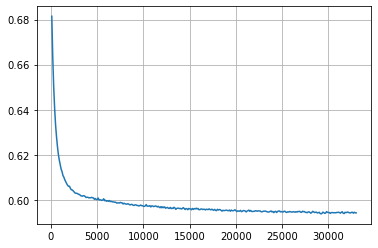

0.005097528042388149


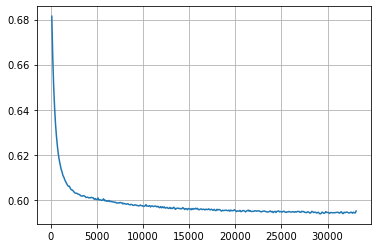

0.0019048330312944018


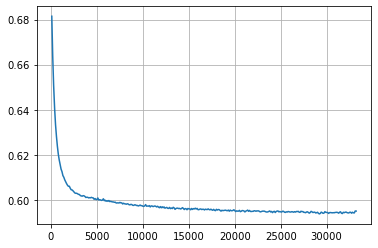

0.0017140224974718876


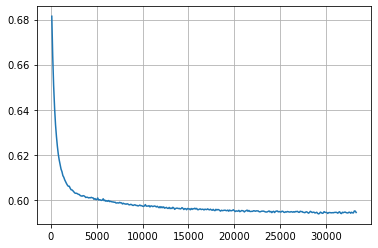

0.0017824157964787446


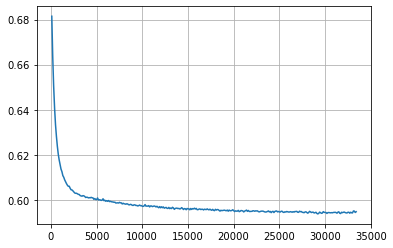

0.0018072281882632523


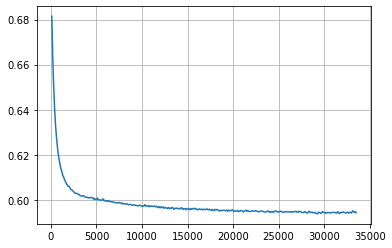

0.0017340253756265155


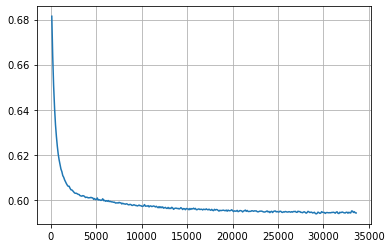

0.001880277417076286


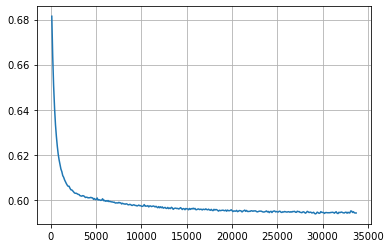

0.001896196476300247


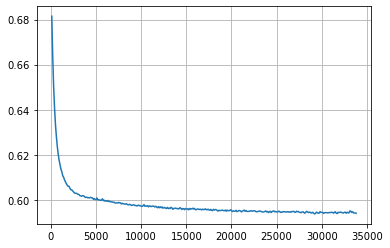

0.0018706006117281504


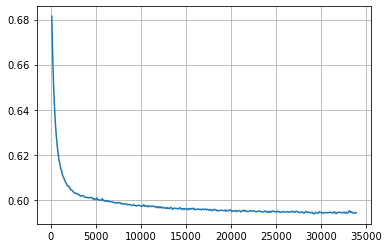

0.002066663252480794


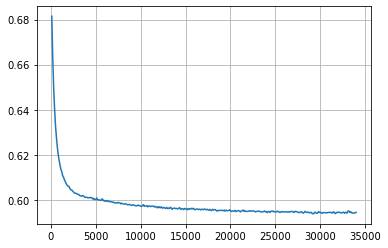

0.0017848052037879826


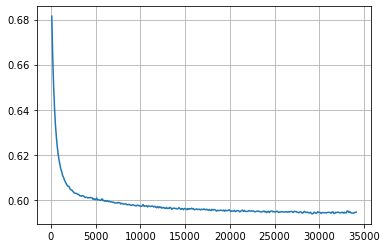

0.0017886524039204233


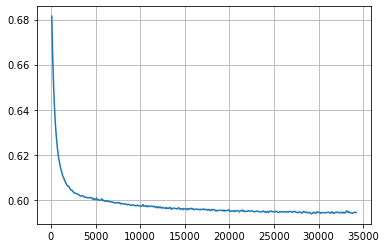

0.0017527715361211448


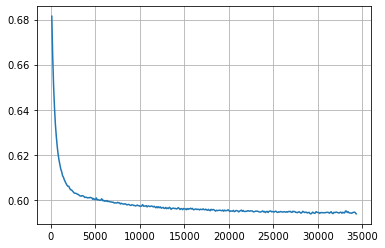

0.0017719560477416963


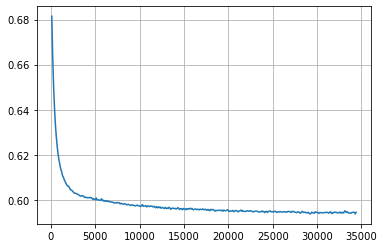

0.0017775949617498555


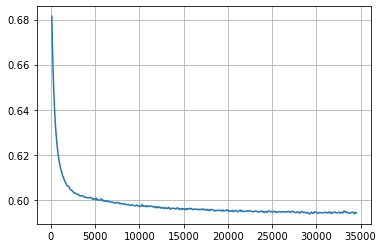

0.0018744789864285848


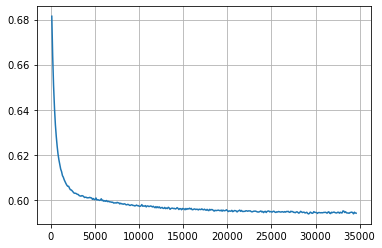

0.0017571680978289805


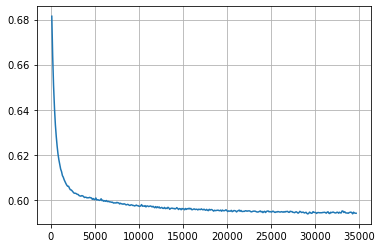

0.0018930010148324073


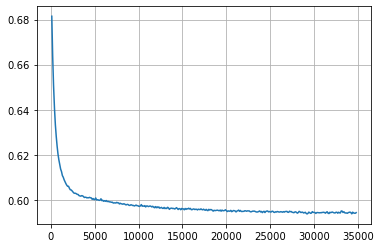

0.0018914517943630926


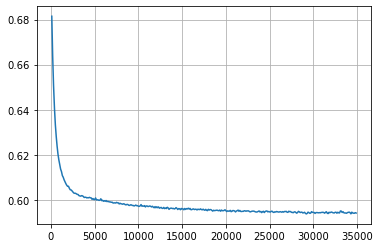

0.001790321531589143


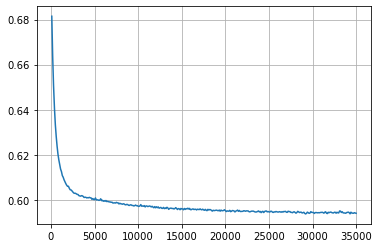

0.0018202635136549362


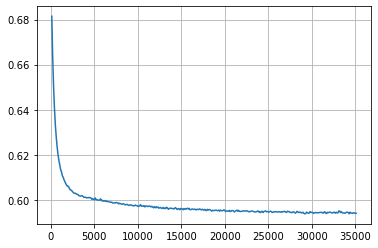

0.002007093025604263


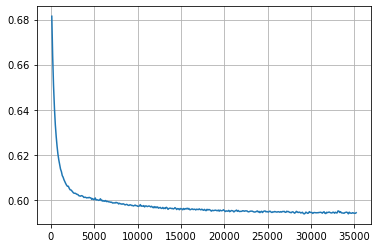

0.001867917994677555


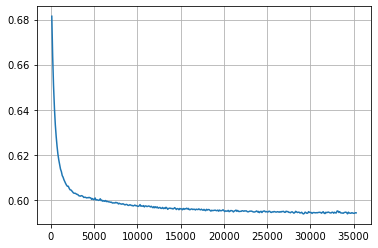

0.0018004258422297426


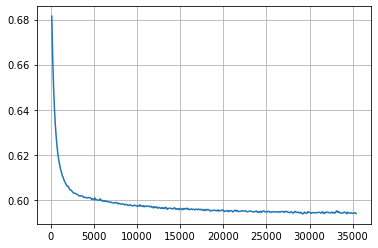

0.0019221227552043273


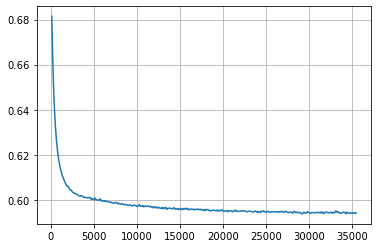

0.0022987020353320985


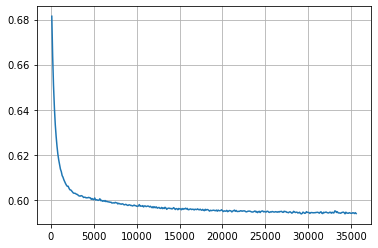

0.0016608043821179307


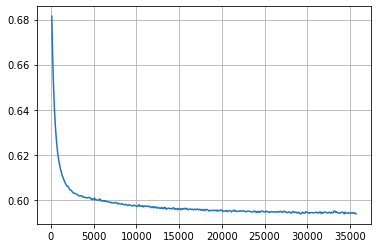

0.0018180958001175896


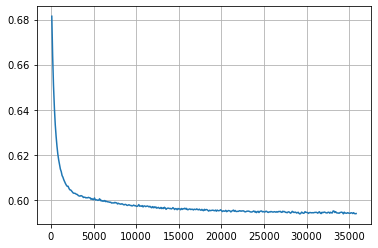

0.0025293461757246406


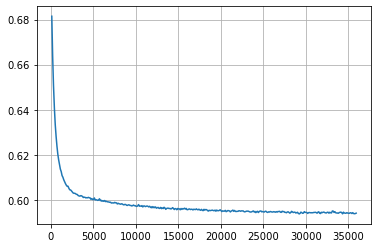

0.0018914725084323437


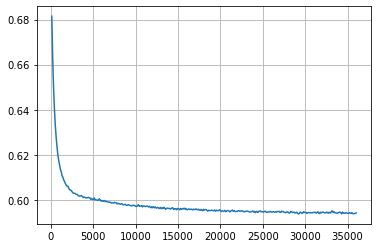

0.0016641463837004267


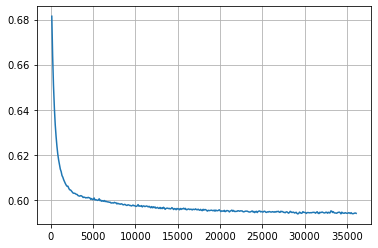

0.0020043534063734114


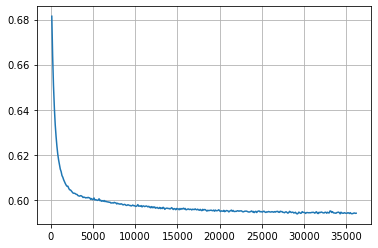

0.0016683857812313362


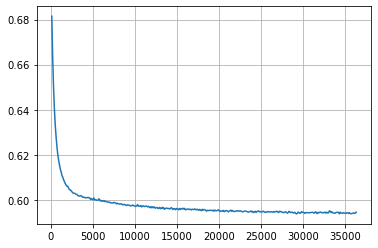

0.001697786660224665


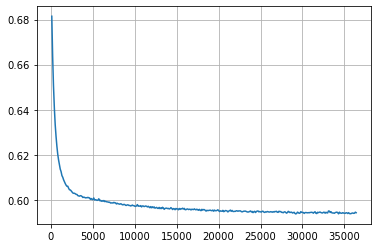

0.001743037147098221


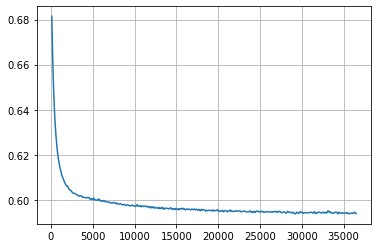

0.0016244081911281683


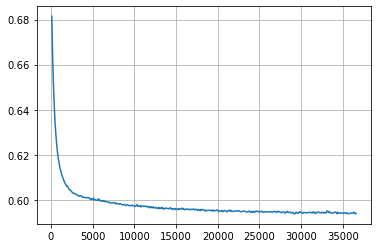

0.0017280974207096733


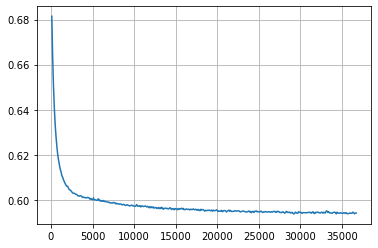

0.0020705442535108886


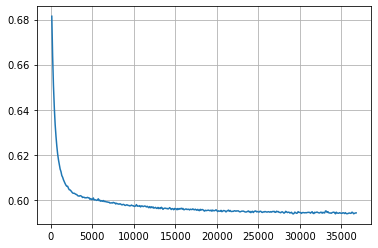

0.0018029609328368678


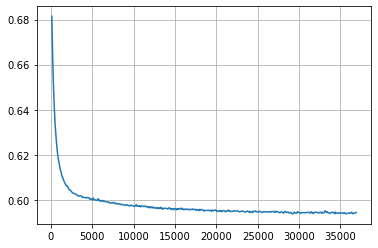

0.0018496736919041722


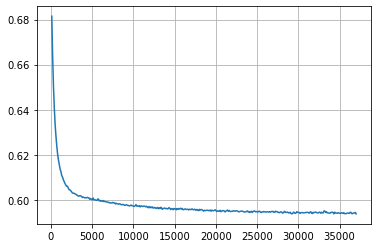

0.001854088685940951


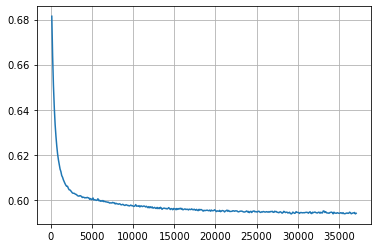

0.0017221763636916876


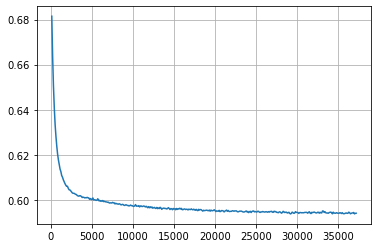

0.0017229255347047002


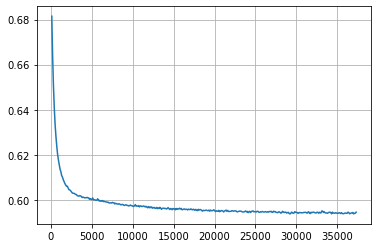

0.0016732496305485256


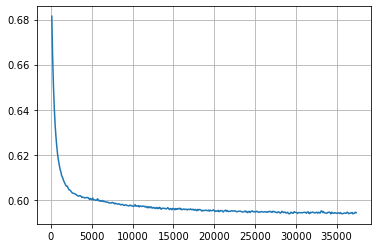

0.0017074235662585125


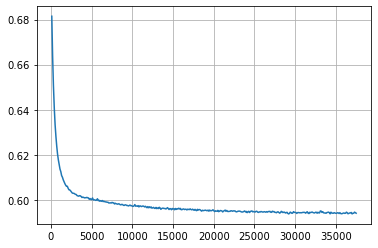

0.001748808172706049


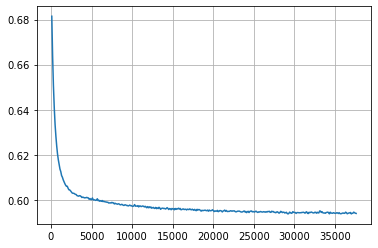

0.0024267243890790267


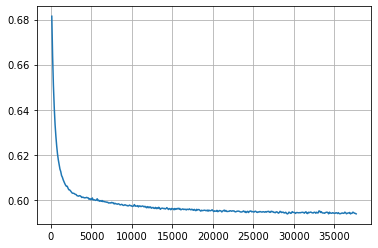

0.0022368880652356895


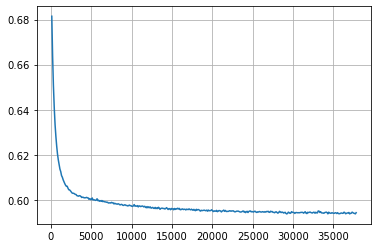

0.0019021717194118537


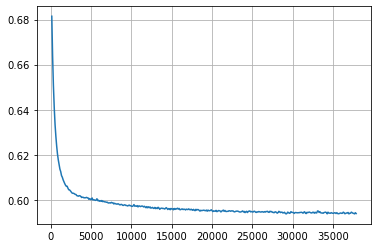

0.0016679880855372175


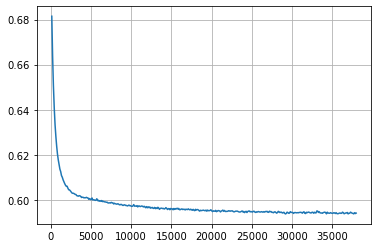

0.0016491598551510833


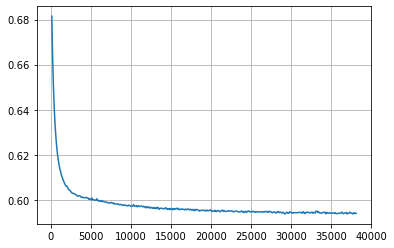

0.0016729599979589693


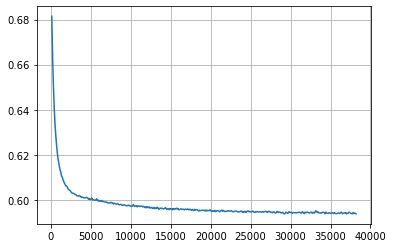

0.0015626735115074552


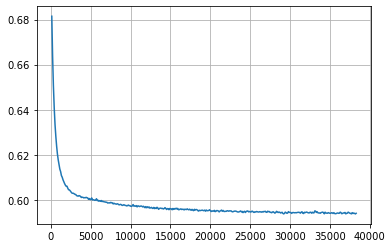

0.0017611646879231557


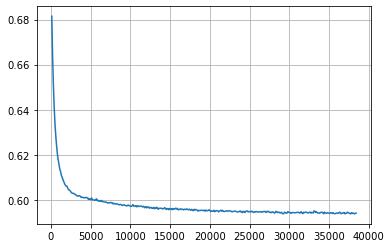

0.0015657240571454168


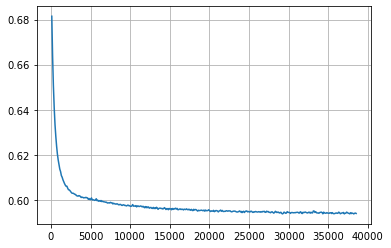

0.0021113185680587776


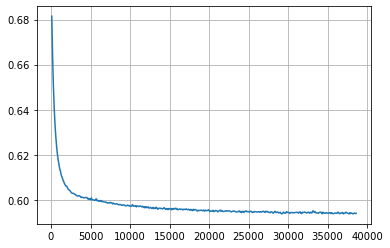

0.0017130752306547946


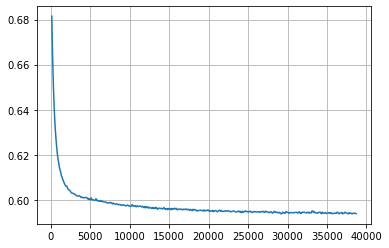

0.0018927564716432243


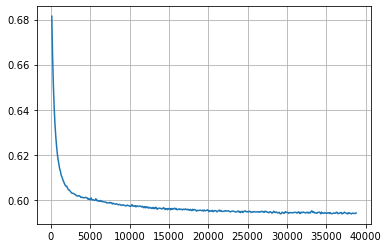

0.0016065720474580302


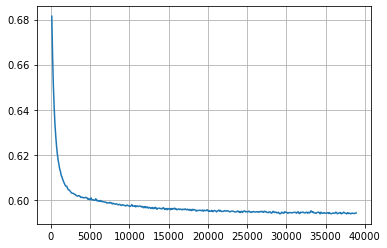

0.0015638493810547515


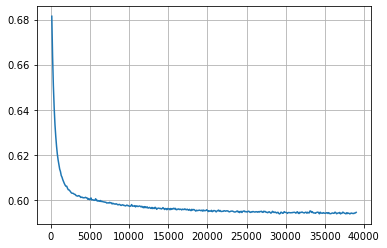

0.0016635250975377857


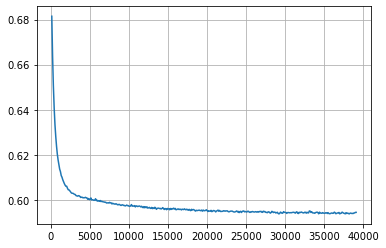

0.0015759091582731343


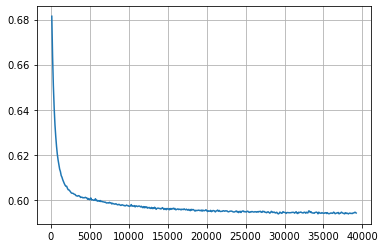

0.0015591837943065912


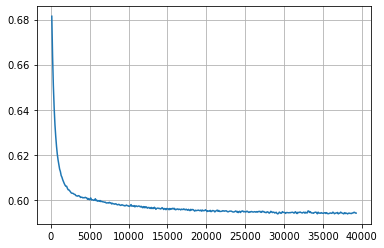

0.0016845795954577624


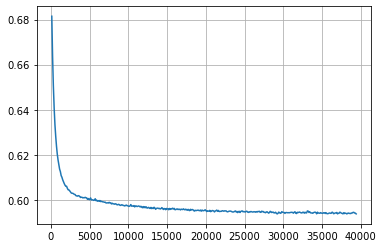

0.0018026756090694107


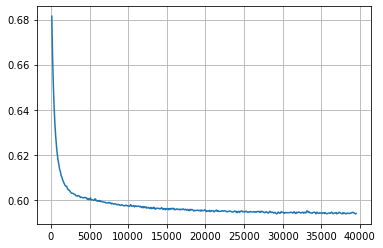

0.0022160922494367697


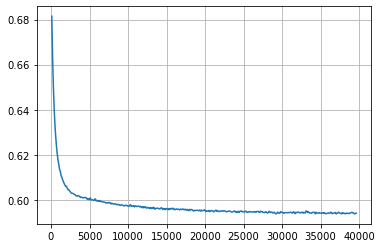

0.0015685726853553205


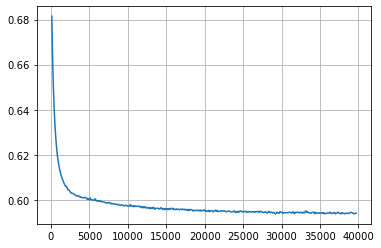

0.0015096860153425951


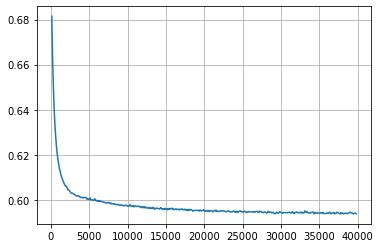

0.002152440171339549


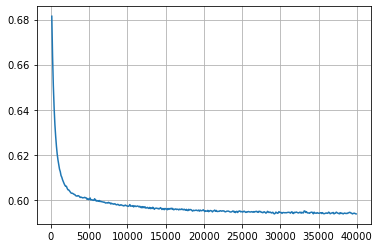

0.001701622310501989


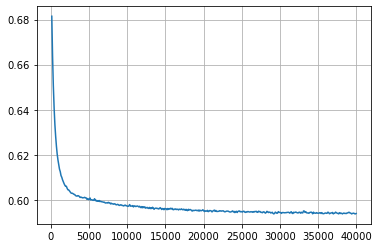

0.0014534298647777178


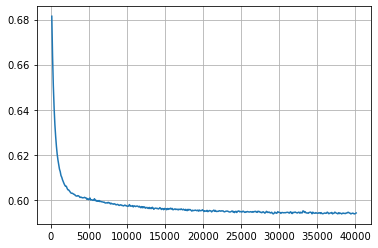

0.0016608105559134856


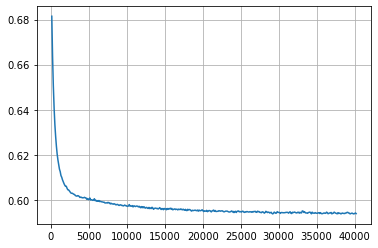

0.002302983960835263


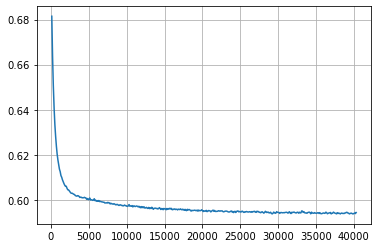

0.0019872388502699323


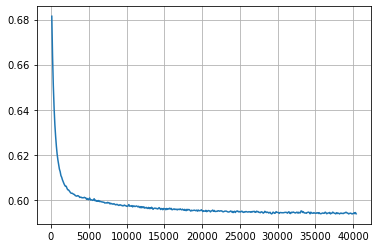

0.0021048188797431065


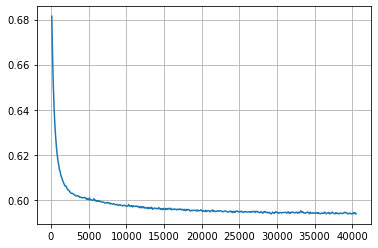

0.001988858036347665


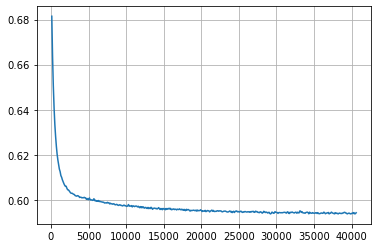

0.0017972685224958696


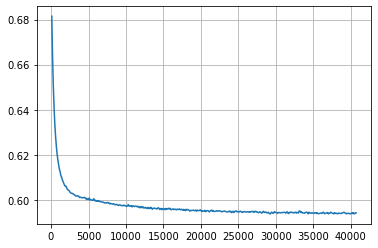

0.0015735870148637333


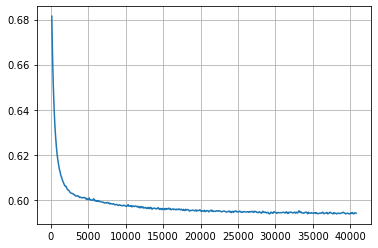

0.0014445251956931315


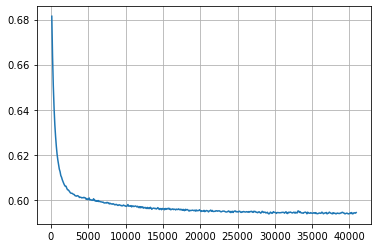

0.001479870424955152


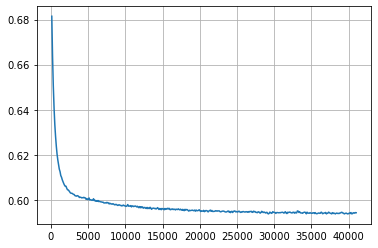

0.0016768239525845273


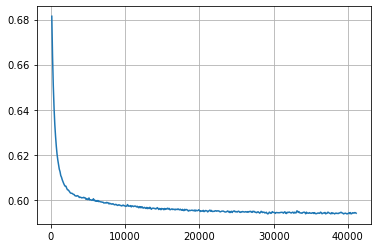

0.0018122095157741568


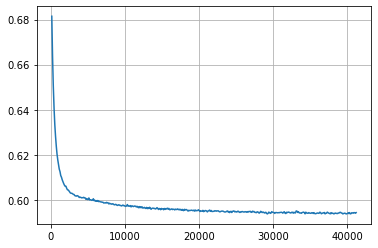

0.0017728670680662616


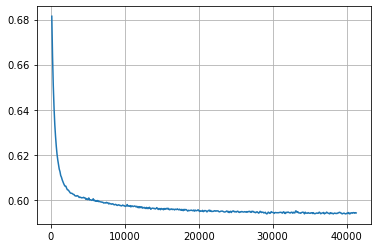

0.0015161530426121316


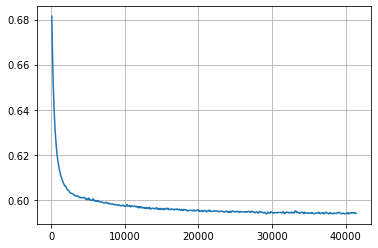

0.0018068187875906006


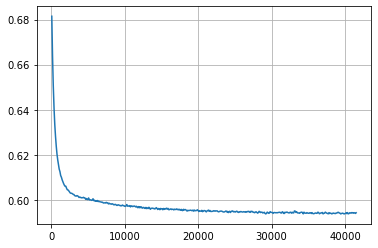

0.0020521955174626783


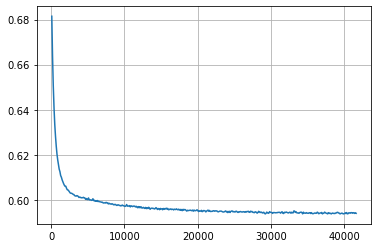

0.0019121372650261037


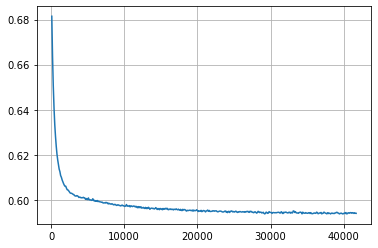

0.001579227593028918


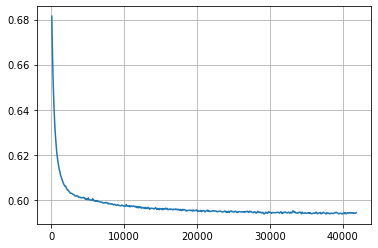

0.0016658712169737556


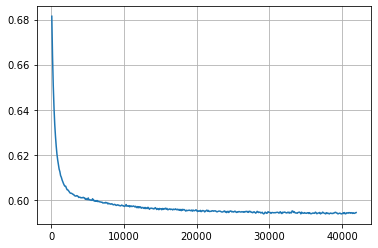

0.0017621743041672743


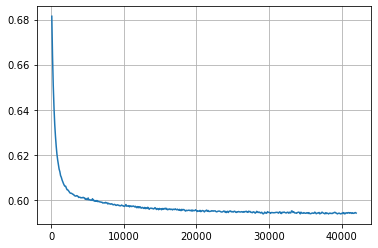

0.0015974876991822384


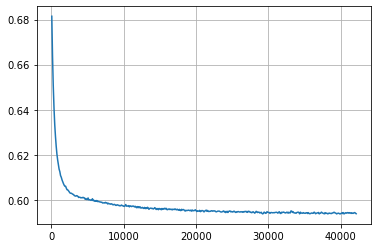

0.0016490305674960837


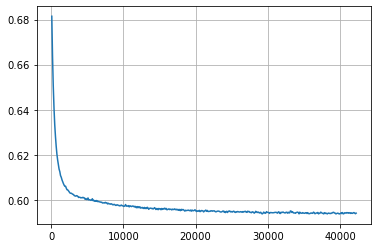

0.0015220782038522884


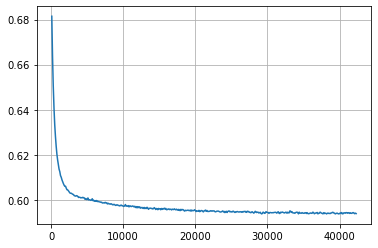

0.0016808708937605843


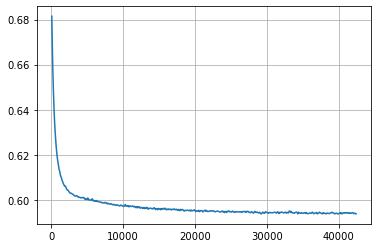

0.0016597571776947007


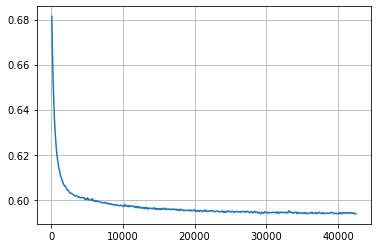

0.0015728951740311458


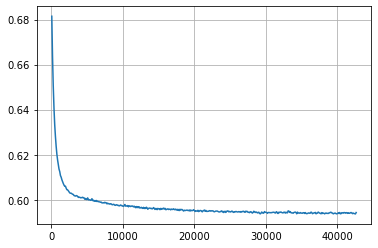

0.001603343384922482


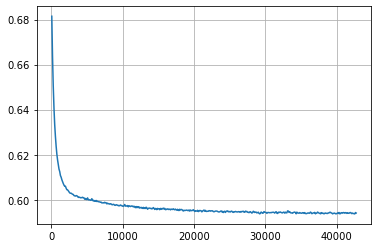

0.0013699476420879365


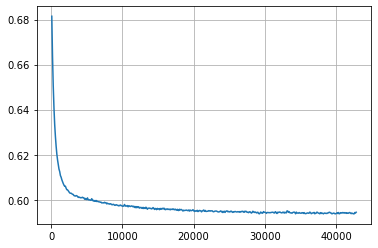

0.0014967202680418268


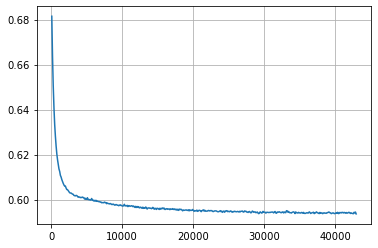

0.002009745663381182


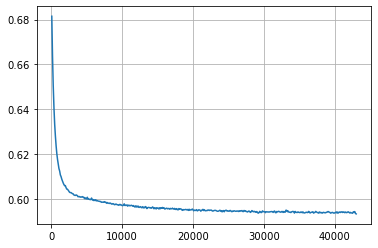

0.0019052982141147367


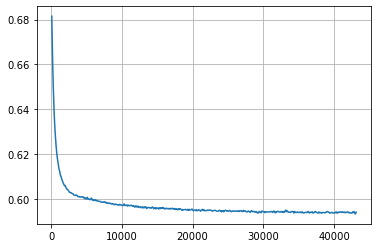

0.0026523528515826913


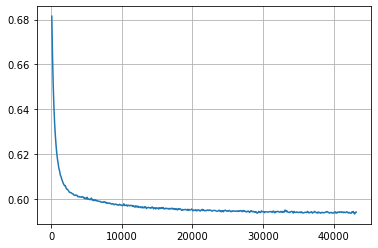

0.0018160749392700383


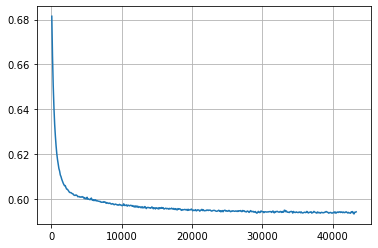

0.0017068439268041401


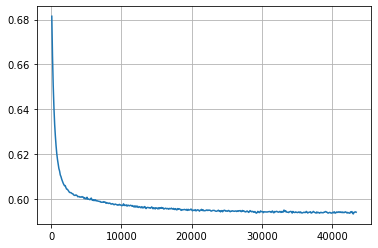

0.0017485534615116194


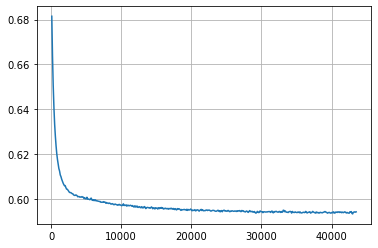

0.001683774515404366


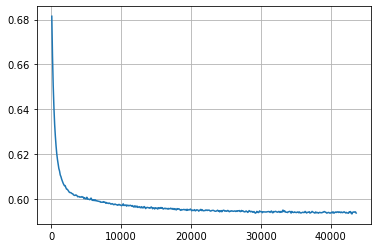

0.001811945061199367


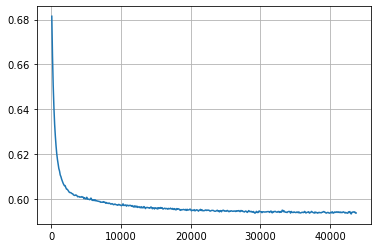

0.001715464550361503


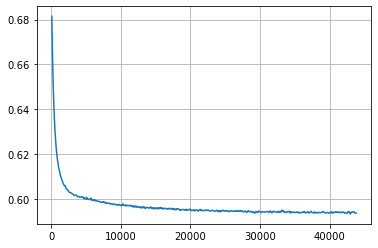

0.001512352205172647


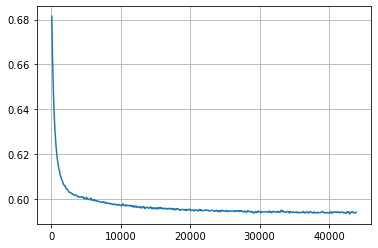

0.0015754991525318473


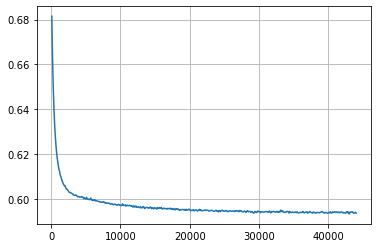

0.0015120774574461393


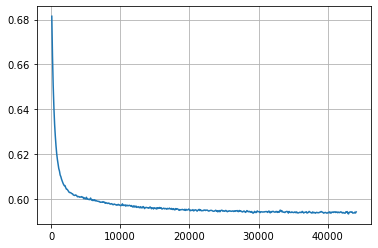

0.0016115665272809566


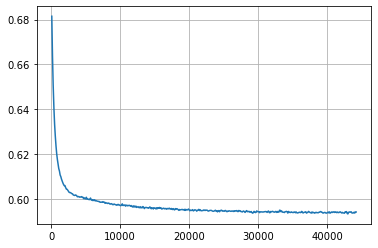

0.002345607902680058


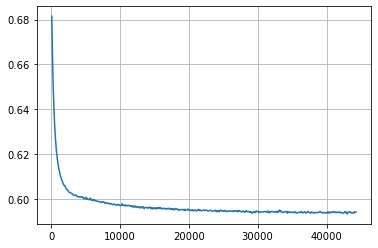

0.0017392591989482753


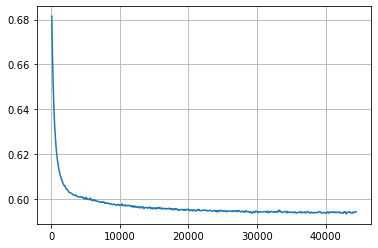

0.0019422498991480098


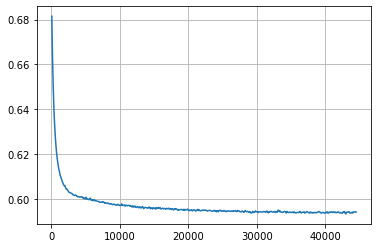

0.001581089575192891


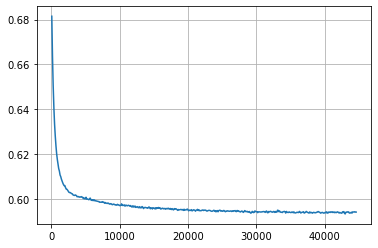

0.001415112586983014


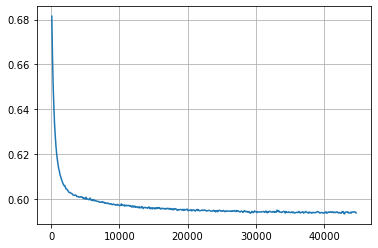

0.001529311538033653


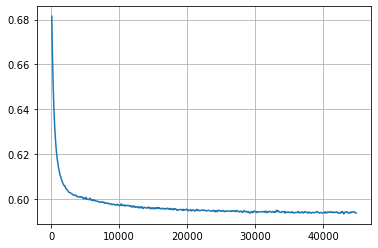

0.00157722967909649


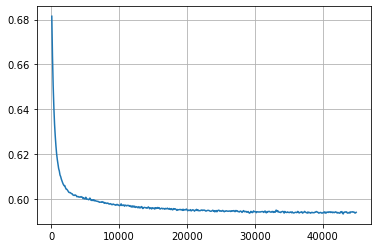

0.0018146066379267722


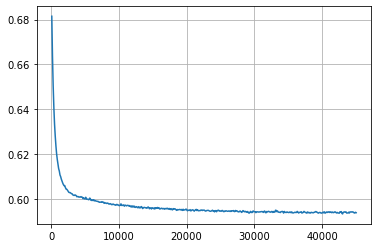

0.0014642096456373111


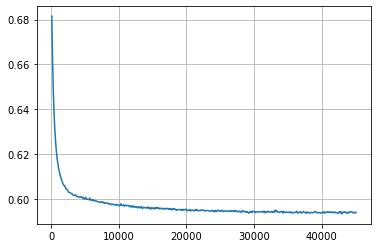

0.0022366345865884795


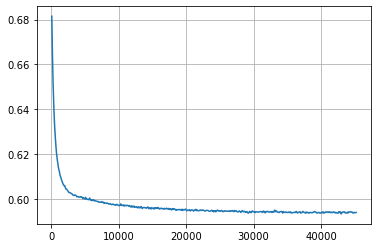

0.001664987197436858


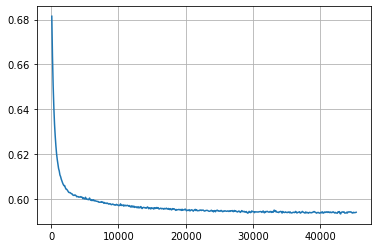

0.0015594938267895486


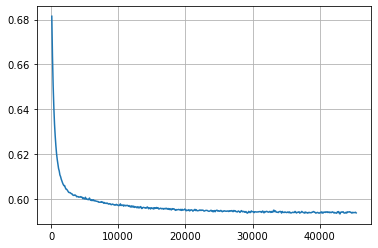

0.00132094362139469


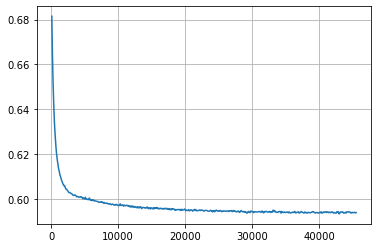

0.0015696989942807704


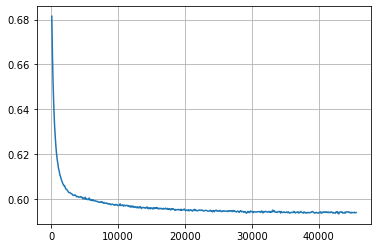

0.0018230647180462257


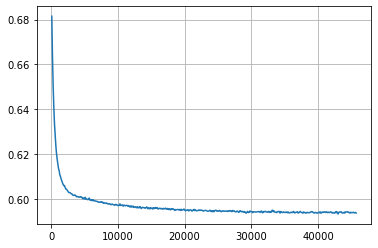

0.0020300650858553126


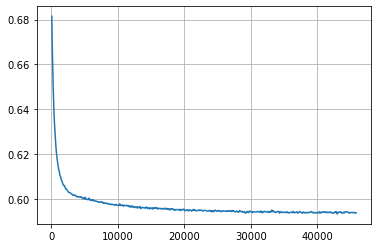

0.0013247415662044658


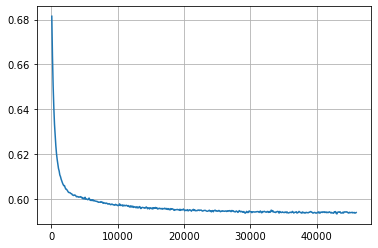

0.0016136319228098727


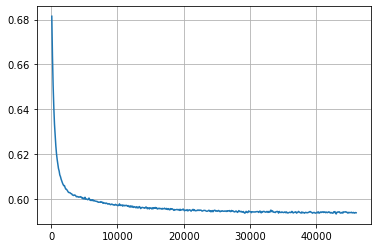

0.0016063250639126636


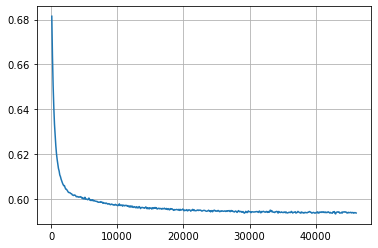

0.002147445965092629


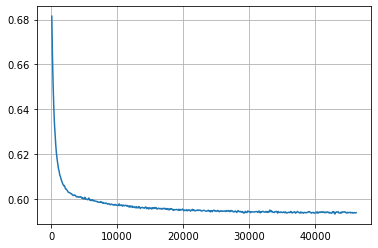

0.0015090228157350794


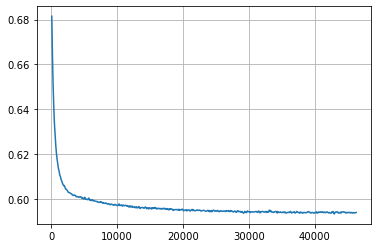

0.001575693650811445


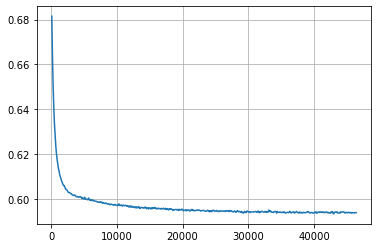

0.0013367028563516215


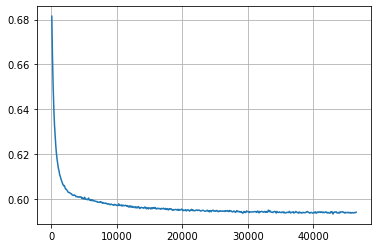

0.0014076370693510399


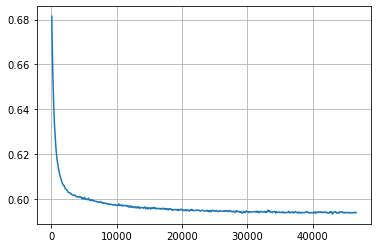

0.0013929032208397985


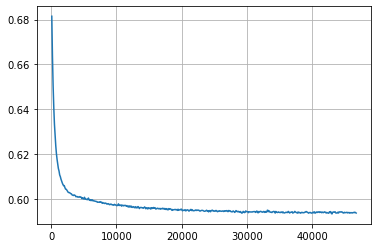

0.0014040669467067345


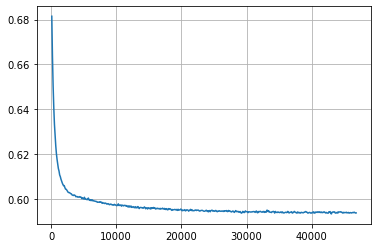

0.0015871195204090326


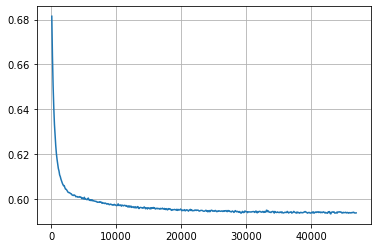

0.0014393696884508244


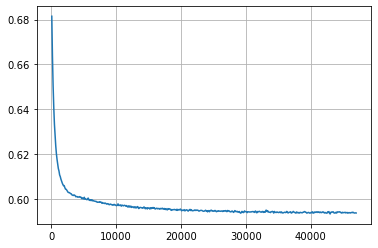

0.001966058929101564


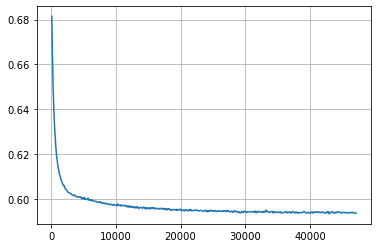

0.001483833886741195


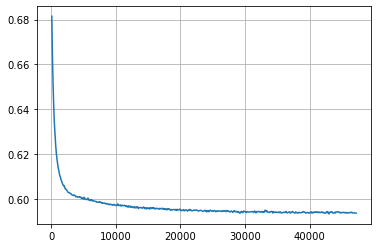

0.0017341741803102194


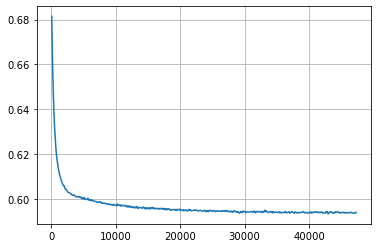

0.0015601779424468986


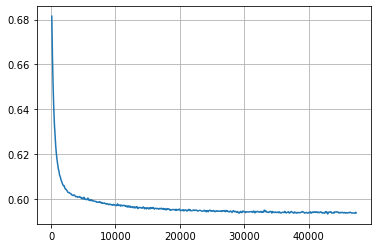

0.0014934604632435367


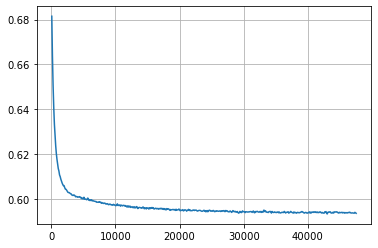

0.0013993529658182524


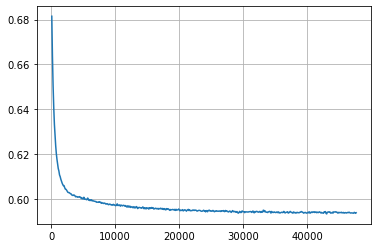

0.0015301617368822917


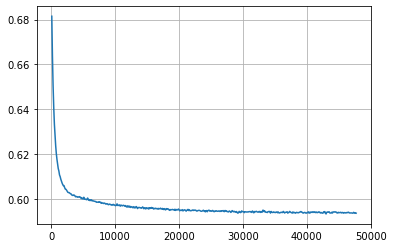

0.0014639788572094403


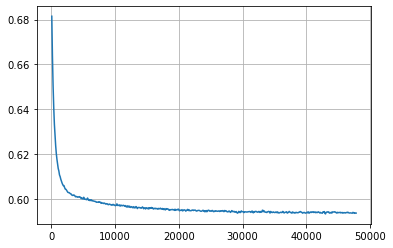

0.0014362027941388078


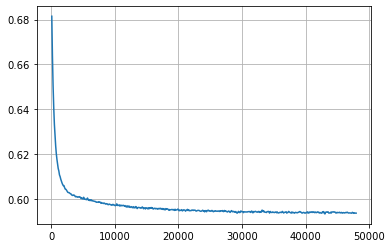

0.0014163399915560148


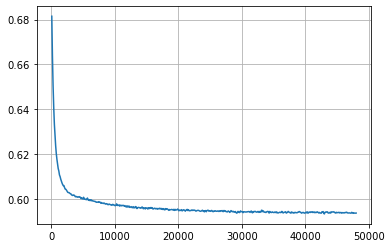

0.0015816538978833704


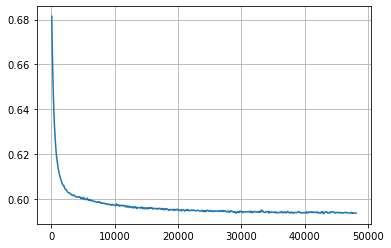

0.0015337271164753475


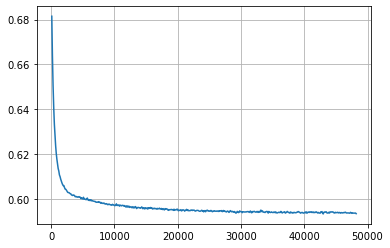

0.0013139231505920178


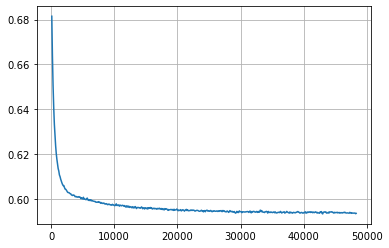

0.001568415231013205


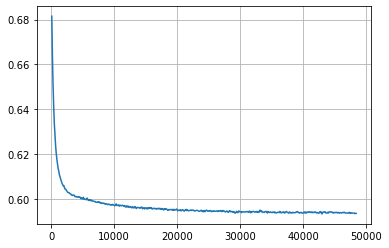

0.0013194128044415265


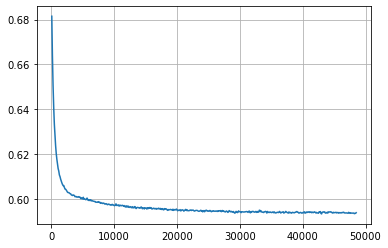

0.0016306381206959487


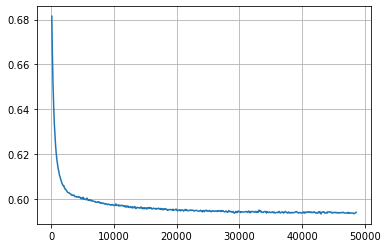

0.001494142802839633


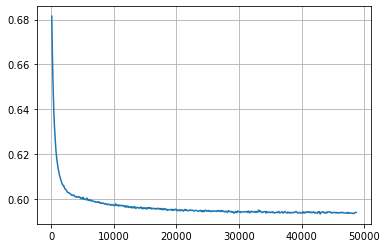

0.0014706184520036913


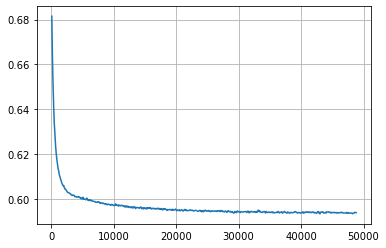

0.0014703418032149785


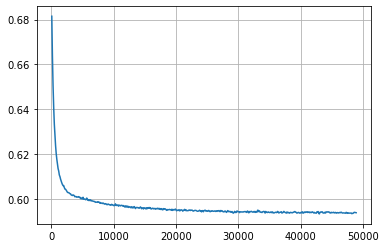

0.0013436245563207194


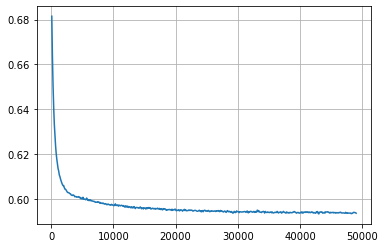

0.001295478826505132


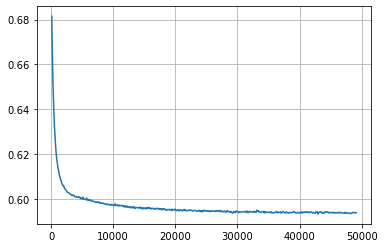

0.0013278209816780873


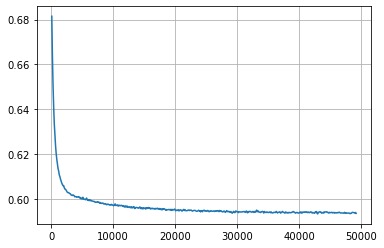

0.0013869914616225288


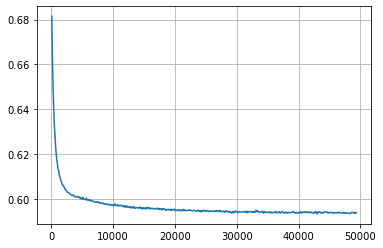

0.0017569623308372683


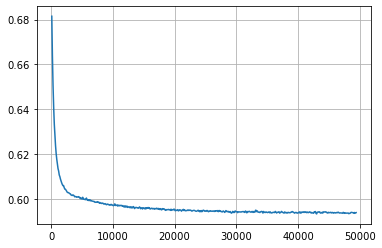

0.0016916128419688903


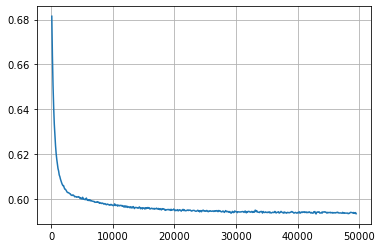

0.0030431770693394354


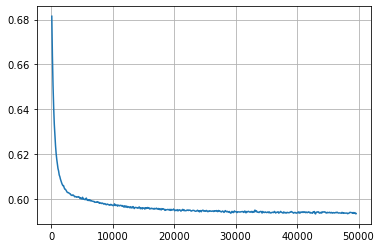

0.003469475713209249


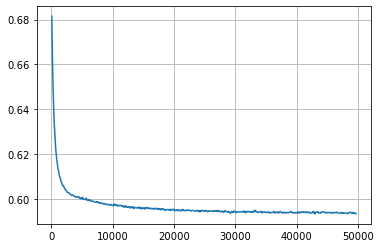

0.0016333324366132728


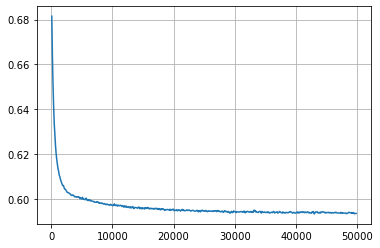

0.001538889218645636


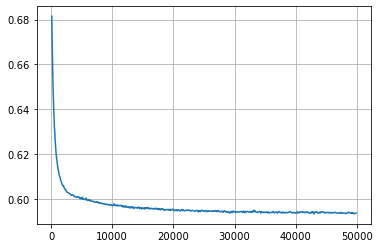

0.001572517165041063


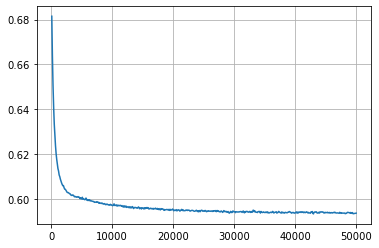

0.0014359697118925395


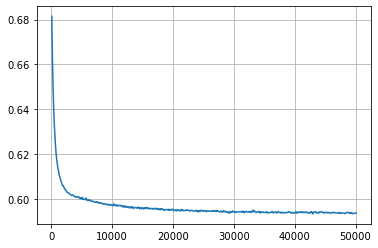

0.0015612081561994272


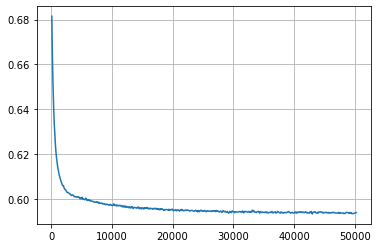

0.0014858151751104742


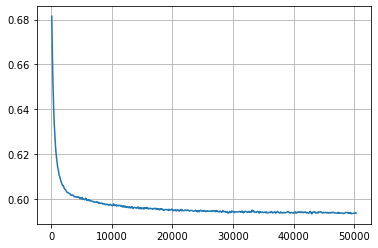

0.001464850813499652


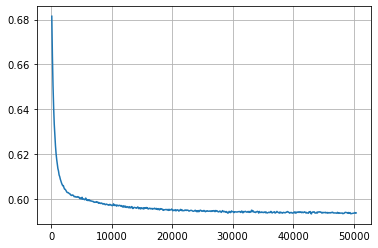

0.0014445675953174942


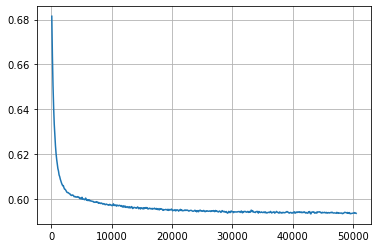

0.001403943159384653


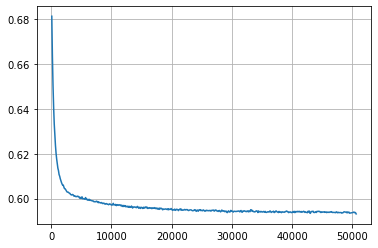

0.0015945688655483537


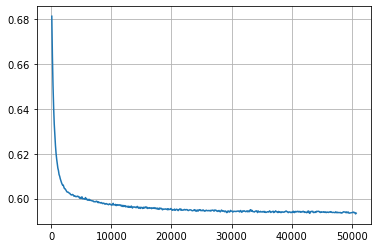

0.0014767691228189505


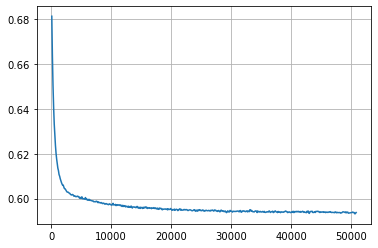

0.001416698310931679


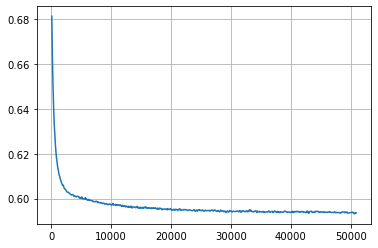

0.001411793527950067


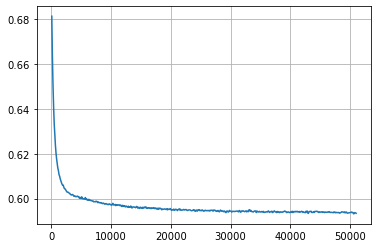

0.0012432403099955991


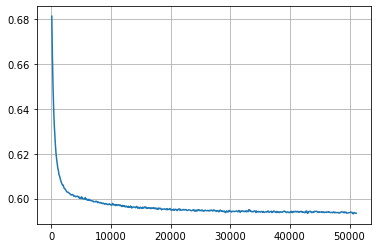

0.0013265243839123287


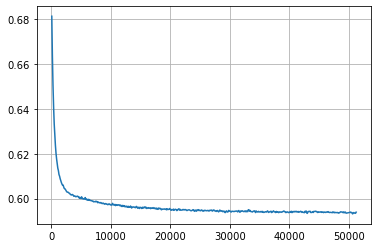

0.0014860231857164762


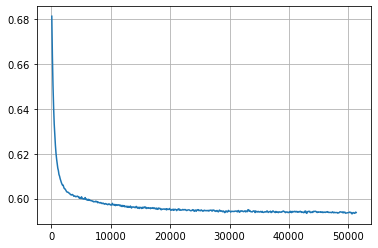

0.0014794361716485582


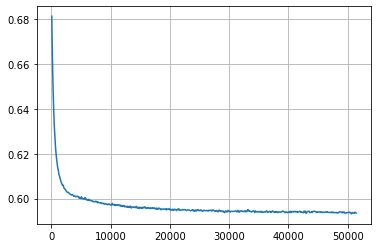

0.0017681664638803342


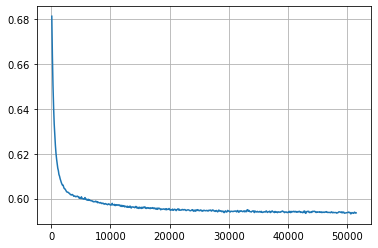

0.0018459336223895662


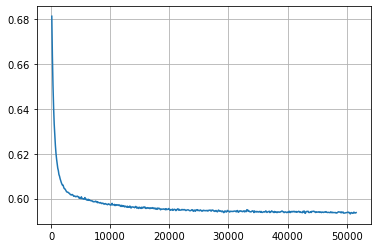

0.0013918721918889786


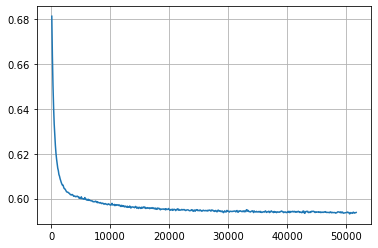

0.001194393424957525


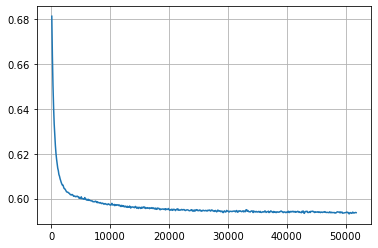

0.001331650519859977


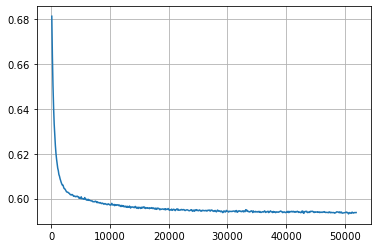

0.001349081824591849


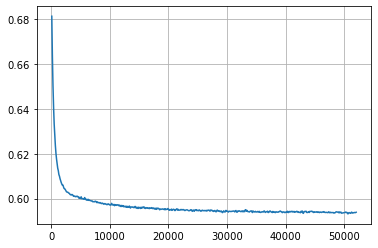

0.0013977121113566682


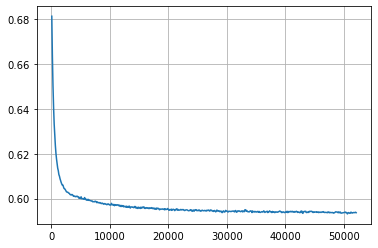

0.0012315028894226998


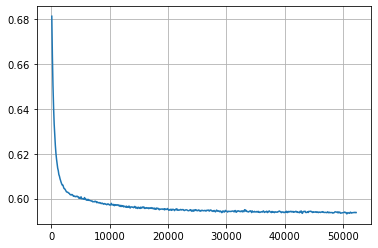

0.001328984247520566


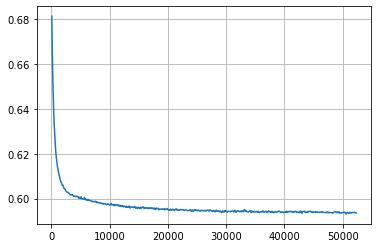

0.0013748236864921637


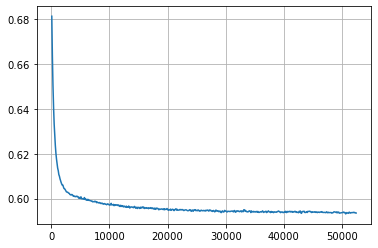

0.0014846962178125978


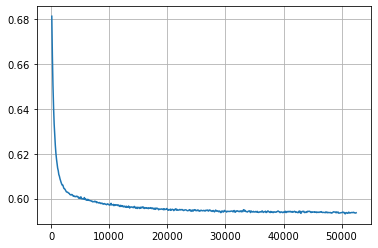

0.001397427998308558


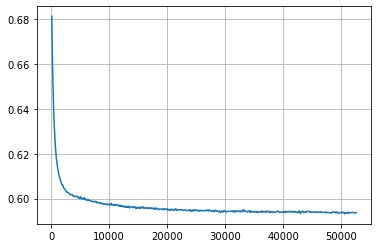

0.0017860617258702405


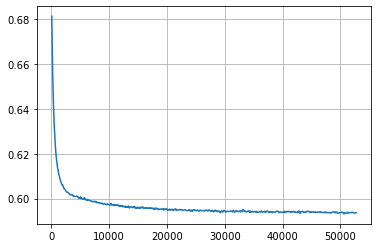

0.0013559443230042234


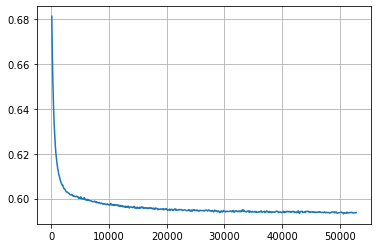

0.001306306369660888


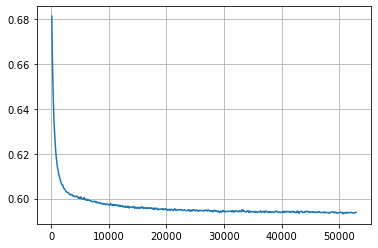

0.0014450178347760812


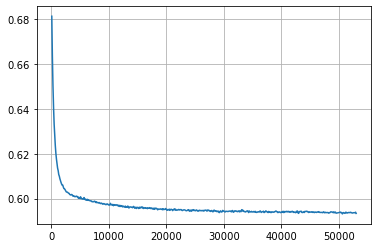

0.0015877642706618644


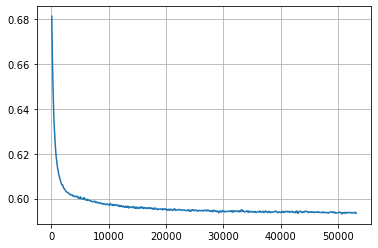

0.0017943185425247066


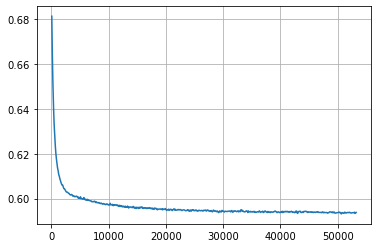

0.0017662503439350985


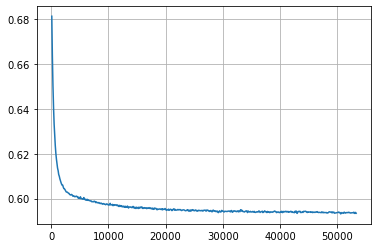

0.0015603937534615397


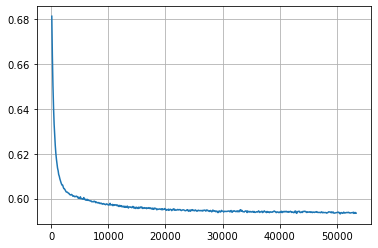

0.001406884810712654


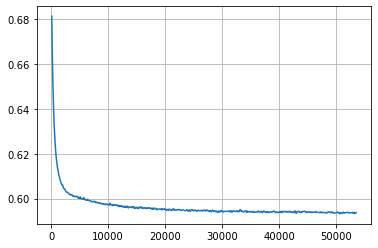

0.0013525841054797638


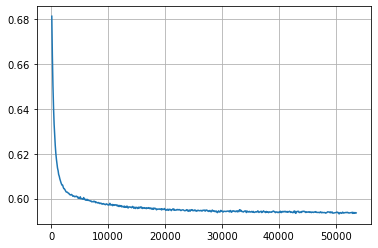

0.00185841187951155


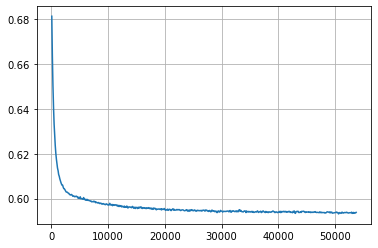

0.0015958466933807358


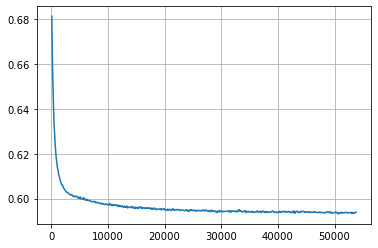

0.0017643451565527357


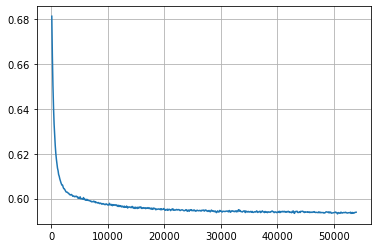

0.0014419635027297772


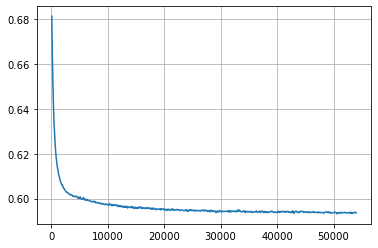

0.0016119605980929918


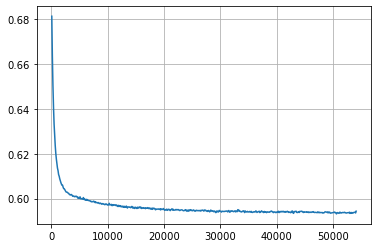

0.0017357184237334878


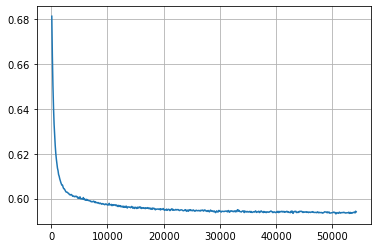

0.0013877723665791564


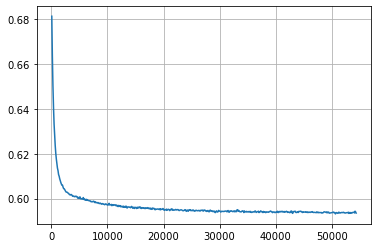

0.0014461940911132843


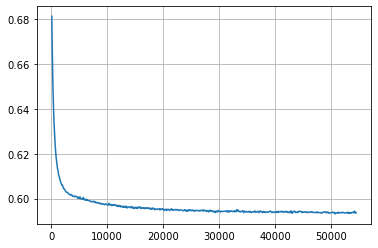

0.0022880992607679216


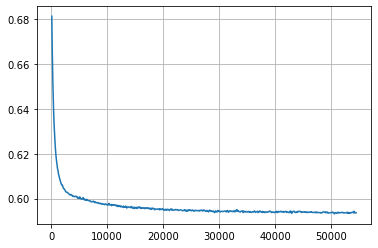

0.0016560319060226903


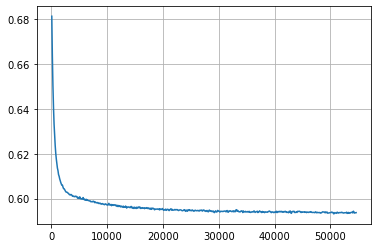

0.0016739630373194814


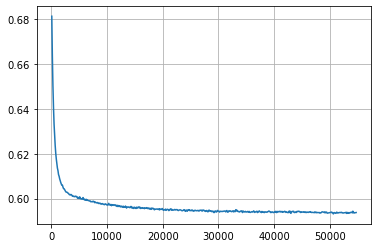

0.0014476105815265329


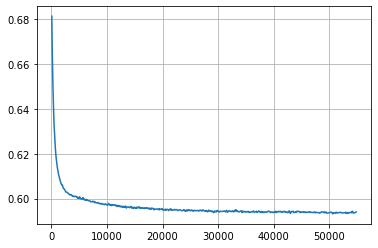

0.0013535613706335426


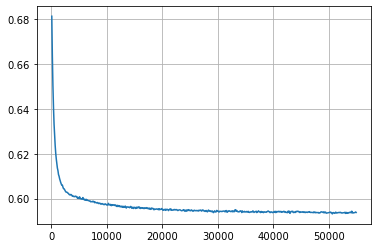

0.0013780011096969247


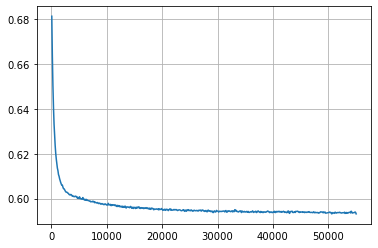

0.001348909678054042


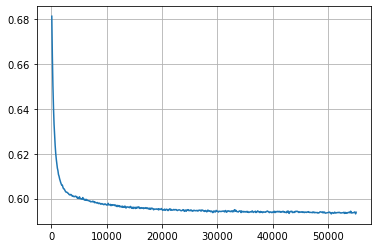

0.001677034882886801


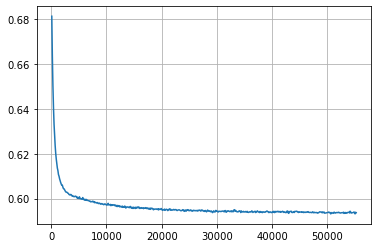

0.0013917321138433181


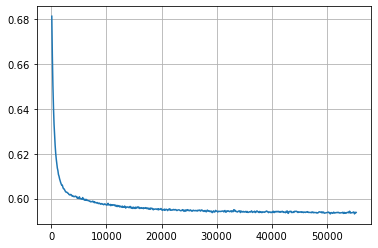

0.0013270427726092748


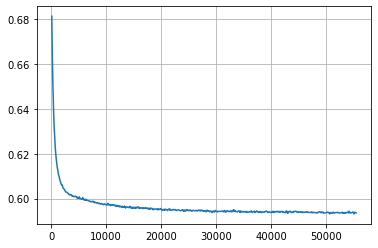

0.0018933349591679872


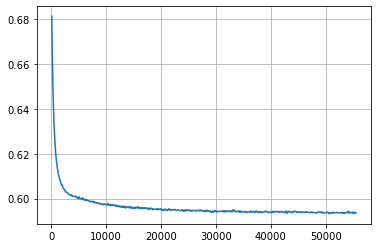

0.0016333419707370922


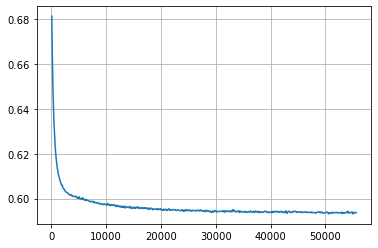

0.0013018719447427428


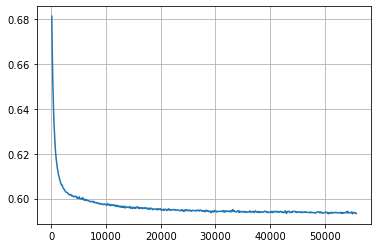

0.0014543785655405372


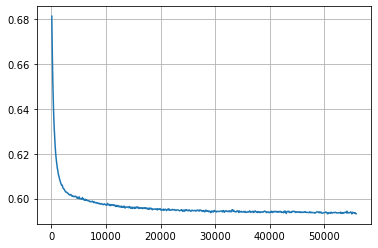

0.0015873061696765945


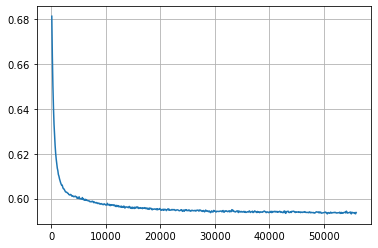

0.0015725439426023512


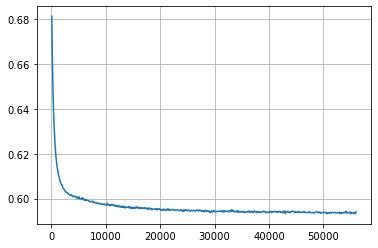

0.0015086313575739042


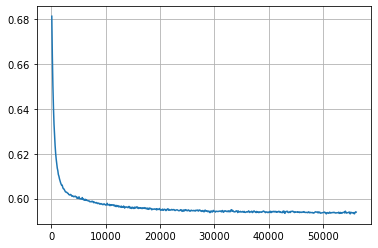

0.0017824409704189747


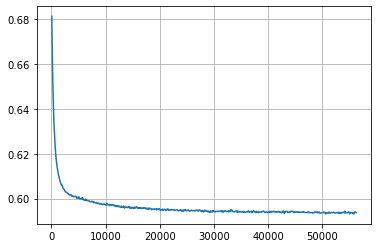

0.0019946651189820842


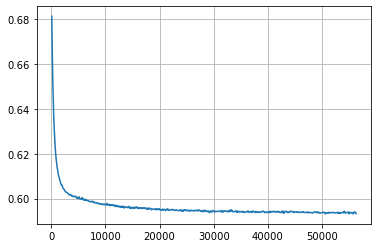

0.0020672679838025943


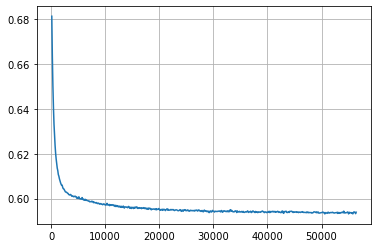

0.0015351062285481022


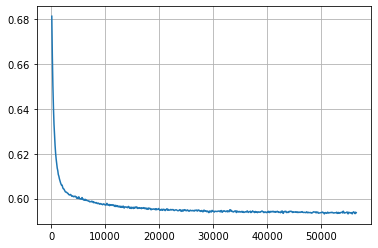

0.0011685555618896615


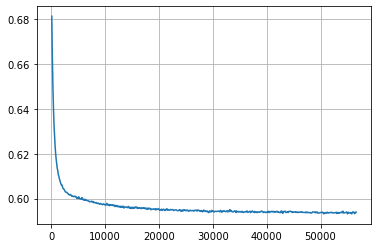

0.0014485546428477391


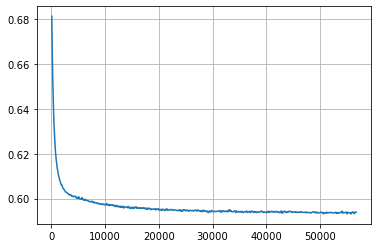

0.001529714289936237


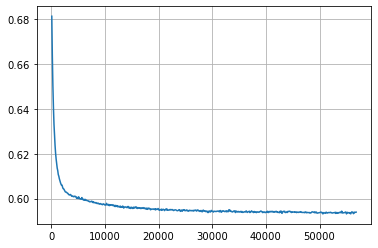

0.0017615866591222584


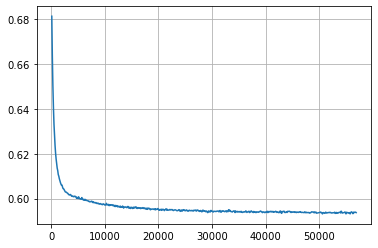

0.001389505154802464


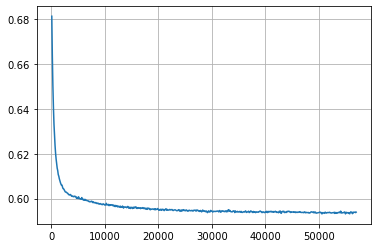

0.0014836854301393033


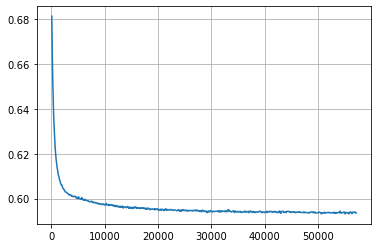

0.00141644757182803


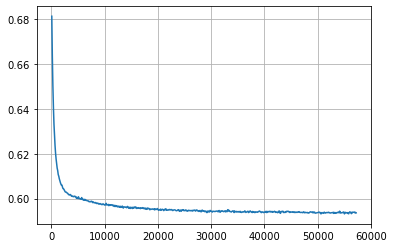

0.0015529552794760094


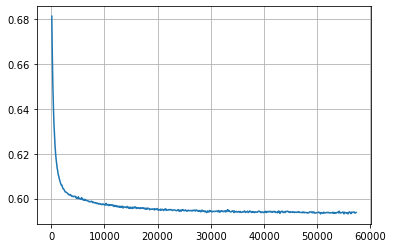

0.0016215600777650253


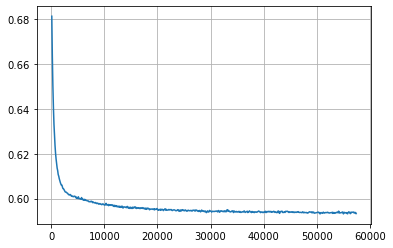

0.0013584841482224873


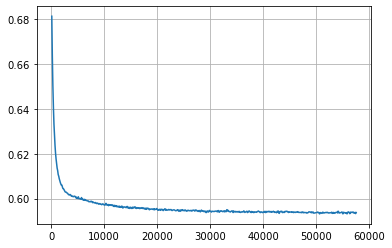

0.0014126978852436877


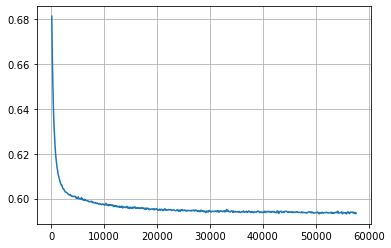

0.0014134908447158523


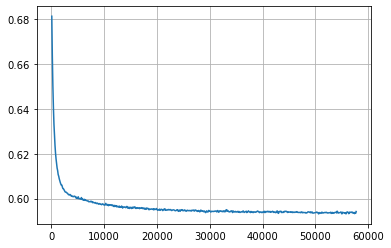

0.0016895023253164253


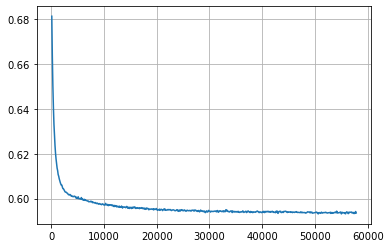

0.0013864971391740256


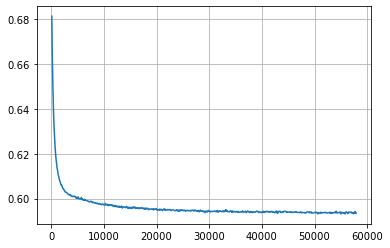

0.0015426870016381144


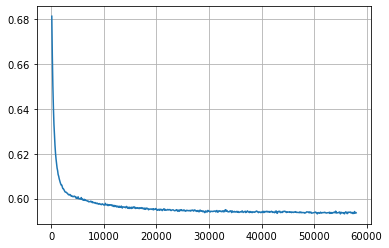

0.0015313403162872418


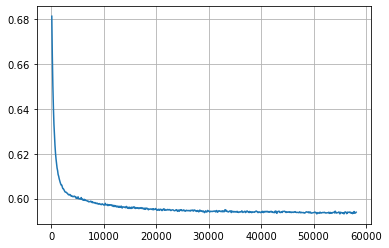

0.001405370731081348


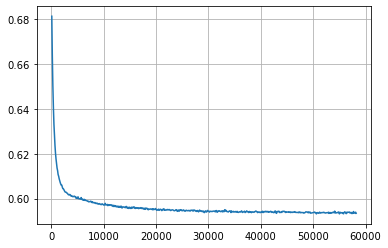

0.0014335508574731648


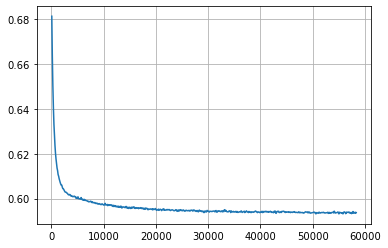

0.001275436436117161


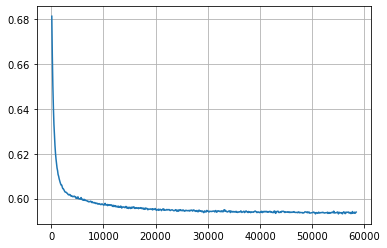

0.001866699676029384


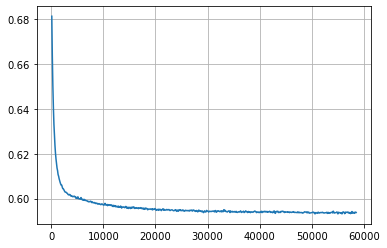

0.0015818784627481364


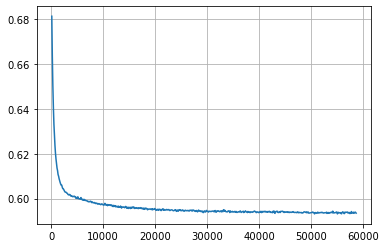

0.0012855555571150035


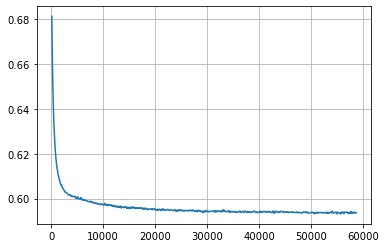

0.0014044899755390361


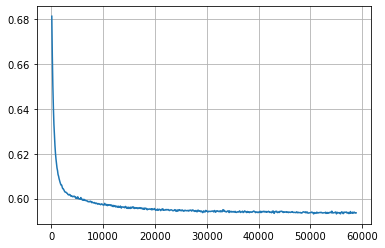

0.0014465624079457483


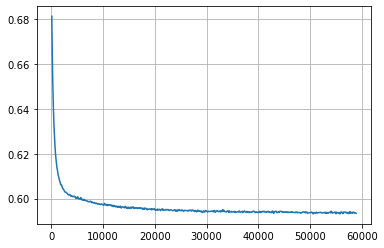

0.002404563387099188


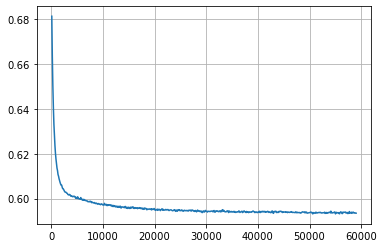

0.0035756033717188984


KeyboardInterrupt: 

In [59]:
criterion = nn.BCELoss()
MSE = nn.MSELoss()
losses = []
slosses = []

for _ in trange(400000):
    
    # Supervised Learning
    x, yt = next(bg)
    x, yt = np2t(x, yt)
    yp = net(x)
    yp = yp * x[:,:,:,[1]] + 0.5 * (1-x[:,:,:,[1]])
    loss = criterion(yp.view(-1), yt.view(-1))
    loss.backward()
    losses += [loss.item()]
        
    # Semisupervised Learning
    x, _ = next(bg)
    x = np2t(x)
    with torch.no_grad():
        y = teacher(x)
    x, y = augment(x, y)
    y2 = net(x)
    sloss = 50*MSE(y, y2)
    sloss.backward()
    slosses += [sloss.item()]
    
    optimizer.step()
    optimizer.zero_grad()
    update_mt(teacher, net, tau)
    
    if len(losses) == 100:
        #print(np.mean(losses))
        print(np.mean(slosses))
        net.losses.append((net.iters, np.mean(losses)))
        losses = []
        slosses = []
        
    if net.iters % 100 == 0:
        plt.plot(*zip(*net.losses))
        #plt.ylim([0.5, 0.61])
        plt.grid()
        plt.show()
        
    if net.iters % 1000 == 0:
        with open('data/battleships_resnet.dat', 'wb') as f:
            torch.save(net.state_dict(), f)
        
    net.iters += 1
        


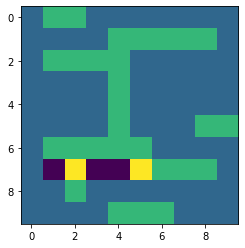

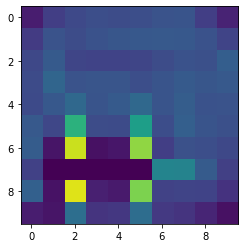

In [21]:
det = create_detection()
#x = torch.from_numpy(encode_x(sea, det)[None,:].astype('float32'))
#prob = net(x)[0,:,:,0].detach().cpu().numpy()
prob = net.predict(encode_x(sea, det))
prob[det > 0] = 0
plt.imshow(visualize(sea, det))
plt.show()
plt.imshow(prob, vmax=1.)
plt.show()

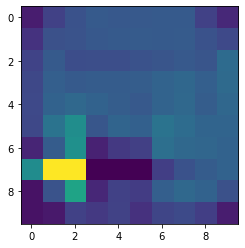

In [22]:
sea = njit_create_sea()
prob = net.predict(encode_x(sea, det))
plt.imshow(prob)

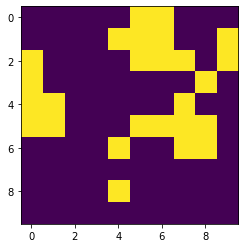

In [24]:
sea = np.zeros((10,10))
det = np.zeros((10,10))
while np.any(1-det):
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    ij = np.random.choice(range(100), p=prob.flatten()/np.sum(prob))
    i, j = divmod(ij, 10)
    det[i,j] = 1
    sea[i,j] = 1 if np.random.rand()<prob[i,j] else 0

    #plt.imshow(visualize(sea, det))
    #plt.show()
    #plt.imshow(prob, vmax=1.)
    #plt.show()
    
plt.imshow(visualize(sea, det))

### AI spielt

In [ ]:
# gegeben: sea, model
det = np.zeros((10,10))
##det = create_detection()
i,j = [],[]


while True:
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    percent = 0. if np.sum(det)==0 else 100*np.sum(det*sea)/(np.sum(det)+1e-2)
    text = f'Hits: %d, Shots: %d, Percentage: %.1f %%' % (np.sum(det*sea), np.sum(det), percent)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    fig.text(1/2,0.8, text, fontdict={})
    ax1.axis('off')
    #ax1.imshow(visualize(sea, det), vmin=0., vmax=3.)
    plot_sea(sea, det, ax1)
    ax1.scatter(j, i, c='black', alpha=1, s=150)
    ax2.axis('off')
    ax2.imshow(prob)
    #plt.title(text)
    plt.show()
    
    # Welchen Detektieren??
    m = prob.argmax()
    i, j = m//10, m%10
    det[i,j] = 1.
    
    #print('______________________________')
    #if (sea[i,j]):
    #    print('Hit him!')
    #else:
    #    print('Failed!')
    #print(f'Hits: {np.sum(det*sea)}/{np.sum(sea)}, Shots: {np.sum(det)}, Percentage: {100*np.sum(det*sea)/np.sum(det)}%')
    
    if np.sum(det*sea) >= np.sum(sea): break
    
    